In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import numpy as np
import json
import tweepy as tw
import nltk
import matplotlib.cm as cm
from nltk.corpus import stopwords
from nltk import bigrams
import re
import networkx as nx
import igraph
import warnings
import community as community_louvain
warnings.filterwarnings("ignore")

## load data

In [2]:
tweet_mis = []
for line in open('./dataset/covid-misinfo-terms-small.json'):
    tweet_mis.append(json.loads(line))


In [4]:
tweet_nonmis1 = []
for line in open('./tweets/coronavirus_smaller_aaaa.json'):
    tweet_nonmis1.append(json.loads(line))
tweet_nonmis2 = []
for line in open('./tweets/coronavirus_smaller_aaab.json'):
    tweet_nonmis2.append(json.loads(line))
tweet_nonmis3 = []
for line in open('./tweets/coronavirus_smaller_aaac.json'):
    tweet_nonmis3.append(json.loads(line))


In [5]:
print(len(tweet_mis))
print(len(tweet_nonmis1),len(tweet_nonmis2),len(tweet_nonmis3))

170636
60000 60000 60000


In [6]:
tweet_nonmis=[]
tweet_nonmis.extend(tweet_nonmis1)
tweet_nonmis.extend(tweet_nonmis2)
tweet_nonmis.extend(tweet_nonmis3)
print(len(tweet_nonmis))

180000


In [7]:
def load_reduced_tweet(tweet):
    if 'referenced_tweets' in tweet: 
        ref_tweets_type= tweet['referenced_tweets'][0]['type']
        ref_tweets_id= tweet['referenced_tweets'][0]['id']
    else:
        ref_tweets_type= None
        ref_tweets_id= None
    reduced_tweet = {
                        'author_id' : tweet['author_id'],
                        'id' : tweet['id'],
                        'lang': tweet['lang'],
                        'referenced_tweets_id' : ref_tweets_id,
                        'referenced_tweets_type' : ref_tweets_type,
                        'text': tweet['text'],
                        'created_at' : tweet['created_at'],
                        'public_metrics' :tweet['public_metrics'], 
                     }
    return reduced_tweet

def load_tweets(tweets):
    reduced_tweets=[]
    for tweet in tweets:
        if 'author_id' in tweet:
            reduced_tweets.append(load_reduced_tweet(tweet))
        elif 'tweets' in tweet:
                for a_single_tweet in tweet["tweets"]:
                    reduced_tweets.append(load_reduced_tweet(a_single_tweet))
    return reduced_tweets
reduced_tweet_mis = load_tweets(tweet_mis)
reduced_tweet_nonmis = load_tweets(tweet_nonmis)
print(len(reduced_tweet_mis),len(reduced_tweet_nonmis))

244449 312850


In [8]:
df_tweet_mis = pd.DataFrame(reduced_tweet_mis)
df_tweet_nonmis = pd.DataFrame(reduced_tweet_nonmis)
df_tweet_mis['ifmis']=1
df_tweet_nonmis['ifmis']=0
data = pd.concat([df_tweet_mis, df_tweet_nonmis], ignore_index=True)
data = data.drop_duplicates(subset=['id'])
data

author_id                   id lang referenced_tweets_id  \
0                 126237449  1366668782677069831   en  1366377045694029828   
1       1245452098935730176  1366668731124838401   en  1366109545727098880   
2                 348795749  1366668486567731201   en                 None   
3       1075763979778187264  1366668198364479488   en  1366514380557402120   
4                 270416438  1366667937298472960   en  1366657340234231812   
...                     ...                  ...  ...                  ...   
557294            467248605  1357388837551411211   en  1357340566187429894   
557295             43300951  1357388837501231105   fr                 None   
557296            288685926  1357388837308092416   en                 None   
557297   803660000069566468  1357388837014618112   es                 None   
557298           2208279067  1357388836997791746   in  1357176360280596482   

       referenced_tweets_type  \
0                   retweeted   
1                  replied_to   
2                        None   
3                  replied_to   
4                  replied_to   
...                       ...   
557294              retweeted   
557295                   None   
557296                   None   
557297                   None   
557298              retweeted   

                                                     text  \
0       RT @lsferguson: Hydroxychloroquine is a safe, ...   
1       @GovInslee Anything helps thank you, @GovInsle...   
2       When they say the second wave of the plandemic...   
3       @PaulWaddington3 @ClarkeMicah I couldnt give a...   
4       @MayorofLondon @BBCNews FUCK YOUR PLANdemic. W...   
...                                                   ...   
557294  RT @ShishirGoUP: UP under CM @myogiadityanath ...   
557295  Coronavirus: vers une nouvelle enveloppe de 7,...   
557296  Officials watching Norfolk South African varia...   
557297  Un colegio deja que sus alumnos no vayan a cla...   
557298  RT @WashalFalah: Terdampak Covid 19, Vino Bast...   

                      created_at  \
0       2021-03-02T08:36:43.000Z   
1       2021-03-02T08:36:31.000Z   
2       2021-03-02T08:35:33.000Z   
3       2021-03-02T08:34:24.000Z   
4       2021-03-02T08:33:22.000Z   
...                          ...   
557294  2021-02-04T18:01:32.000Z   
557295  2021-02-04T18:01:32.000Z   
557296  2021-02-04T18:01:32.000Z   
557297  2021-02-04T18:01:32.000Z   
557298  2021-02-04T18:01:32.000Z   

                                           public_metrics  ifmis  
0       {'retweet_count': 1285, 'reply_count': 0, 'lik...      1  
1       {'retweet_count': 0, 'reply_count': 0, 'like_c...      1  
2       {'retweet_count': 0, 'reply_count': 1, 'like_c...      1  
3       {'retweet_count': 0, 'reply_count': 1, 'like_c...      1  
4       {'retweet_count': 0, 'reply_count': 0, 'like_c...      1  
...                                                   ...    ...  
557294  {'retweet_count': 275, 'reply_count': 0, 'like...      0  
557295  {'retweet_count': 0, 'reply_count': 0, 'like_c...      0  
557296  {'retweet_count': 0, 'reply_count': 0, 'like_c...      0  
557297  {'retweet_count': 0, 'reply_count': 0, 'like_c...      0  
557298  {'retweet_count': 1063, 'reply_count': 0, 'lik...      0  

[425929 rows x 9 columns]

In [11]:
network_data_mis = data[data['ifmis']==1]
network_data_nonmis = data[data['ifmis']==0]
print(len(network_data_mis),len(network_data_nonmis))

213110 212819


In [12]:
network_data_mis=network_data_mis[['id','author_id','referenced_tweets_id']]
network_data_nonmis=network_data_nonmis[['id','author_id','referenced_tweets_id']]

In [13]:
network_data_mis.dropna(subset=['referenced_tweets_id'],inplace=True)
network_data_nonmis.dropna(subset=['referenced_tweets_id'],inplace=True)
print(len(network_data_mis),len(network_data_nonmis))

165564 153745


In [15]:
def find_sourse_author(series):
    referenced_tweets_id = series["referenced_tweets_id"]
    if referenced_tweets_id == '':
        return None
    else:
        sourse_tweet = data[data["id"] == referenced_tweets_id]
        if sourse_tweet.empty:
            return None
        else:
            sourse_author_id = sourse_tweet['author_id'].values.tolist()[0]
        return sourse_author_id


In [ ]:
network_data_mis["Source_author_id"] = network_data_mis.apply(find_sourse_author,axis=1)
network_data_mis.dropna(subset=['Source_author_id'],inplace=True)
network_data_mis

In [33]:
network_data_nonmis["Source_author_id"] = network_data2.apply(find_sourse_author,axis=1)
network_data_nonmis.to_csv("./dataset/network_data_nonmis.csv")
network_data_nonmis

FileNotFoundError: [Errno 2] File ./dataset/network_data_nonmis.csv does not exist: './dataset/network_data_nonmis.csv'

In [34]:
network_data_nonmis

author_id                   id lang referenced_tweets_id  \
244452  1275531383021146112  1357411152720928768   en  1357351156826083328   
244453            344269254  1357411152368648193   es  1357410121274523649   
244454           4825557477  1357411152289009667   en  1357312524404875267   
244455           2866489102  1357411152167337990   en  1357395305625341953   
244458  1211482698708946944  1357411151684993029   en  1357116036647182337   
...                     ...                  ...  ...                  ...   
557288  1259818735130611713  1357388838222585864   en  1357388745151025152   
557291           2664767872  1357388838012919813   es  1357257747889348610   
557292             16898091  1357388837698289664   en  1357358075498418181   
557294            467248605  1357388837551411211   en  1357340566187429894   
557298           2208279067  1357388836997791746   in  1357176360280596482   

       referenced_tweets_type  \
244452              retweeted   
244453              retweeted   
244454              retweeted   
244455              retweeted   
244458                 quoted   
...                       ...   
557288              retweeted   
557291              retweeted   
557292              retweeted   
557294              retweeted   
557298              retweeted   

                                                     text  \
244452  RT @narendramodi: Spoke to President @CyrilRam...   
244453  RT @532_gnb: #GNBJuntoAlPueblo no da tregua en...   
244454  RT @TorontoStar: How risky are Ontario schools...   
244455  RT @dankennedy_nu: Now up at @storybench: How ...   
244458  This is considered a felony with Covid going o...   
...                                                   ...   
557288  RT @NewtonClarkeUK: Funny what can be achieved...   
557291  RT @PabloFuente: #COVID19 Cribado masivo en Co...   
557292  RT @TheBarbarienne: If the flu got this big a ...   
557294  RT @ShishirGoUP: UP under CM @myogiadityanath ...   
557298  RT @WashalFalah: Terdampak Covid 19, Vino Bast...   

                      created_at  \
244452  2021-02-04T19:30:12.000Z   
244453  2021-02-04T19:30:12.000Z   
244454  2021-02-04T19:30:12.000Z   
244455  2021-02-04T19:30:12.000Z   
244458  2021-02-04T19:30:12.000Z   
...                          ...   
557288  2021-02-04T18:01:32.000Z   
557291  2021-02-04T18:01:32.000Z   
557292  2021-02-04T18:01:32.000Z   
557294  2021-02-04T18:01:32.000Z   
557298  2021-02-04T18:01:32.000Z   

                                           public_metrics  ifmis  \
244452  {'retweet_count': 4056, 'reply_count': 0, 'lik...      0   
244453  {'retweet_count': 5, 'reply_count': 0, 'like_c...      0   
244454  {'retweet_count': 43, 'reply_count': 0, 'like_...      0   
244455  {'retweet_count': 1, 'reply_count': 0, 'like_c...      0   
244458  {'retweet_count': 0, 'reply_count': 0, 'like_c...      0   
...                                                   ...    ...   
557288  {'retweet_count': 8, 'reply_count': 0, 'like_c...      0   
557291  {'retweet_count': 580, 'reply_count': 0, 'like...      0   
557292  {'retweet_count': 104, 'reply_count': 0, 'like...      0   
557294  {'retweet_count': 275, 'reply_count': 0, 'like...      0   
557298  {'retweet_count': 1063, 'reply_count': 0, 'lik...      0   

           Source_author_id  
244452             18839785  
244453  1165693742638084096  
244454             12848262  
244455             15675013  
244458             24736864  
...                     ...  
557288  1199753098824159233  
557291             62814101  
557292            239930106  
557294  1085192208955756548  
557298            600656087  

[153745 rows x 10 columns]

In [36]:
network_data_nonmis.dropna(subset=['Source_author_id'],inplace=True)
print(len(network_data_nonmis))

144663


In [21]:
network_data2=pd.read_csv("./dataset/network_data2.csv")

In [37]:
network_data_nonmis.to_csv("./dataset/network_data3.csv",index=False)

In [16]:
network_data1["Source_author_id"] = network_data1.apply(find_sourse_author,axis=1)
network_data1

NameError: name 'network_data1' is not defined

In [22]:
network_data1.dropna(subset=['Source_author_id'],inplace=True)
network_data2.dropna(subset=['Source_author_id'],inplace=True)
print(len(network_data1),len(network_data2))

152137 47787


In [24]:
network_data1= network_data1[['author_id', 'Source_author_id']]
network_data1['weight']=0
network_data1=network_data1.groupby(['author_id', 'Source_author_id'], as_index=False).count()
network_data1['ifmis']=1
network_data2= network_data2[['author_id', 'Source_author_id']]
network_data2['weight']=0
network_data2=network_data2.groupby(['author_id', 'Source_author_id'], as_index=False).count()
network_data2['ifmis']=0
network_data=pd.concat([network_data1, network_data2], ignore_index=True)

In [25]:
network_data.to_csv("./dataset/network_data.csv",index=False)

In [26]:
network_data.apply(lambda x: x.nunique())

author_id           119594
Source_author_id     41578
weight                  69
ifmis                    2
dtype: int64

In [27]:
id1=network_data.author_id.unique().tolist()
id2=network_data.Source_author_id.unique().tolist()
id3=id1+id2
id4 = list(set(id3)) 
dic_id = {id4[i]:i for i in range(len(id4))}
dic_id

{700645316748378112: 0,
 701239510734995456: 1,
 702890874200391680: 2,
 '2353949707': 3,
 703568996851777536: 4,
 704348135397523457: 5,
 705652937796616192: 6,
 '129654658': 7,
 708115569715707905: 8,
 '1282316726227603457': 9,
 755099753302458369: 10,
 776468108370247685: 11,
 851636768696696837: 12,
 882894545620303876: 13,
 '1080981008072216577': 14,
 '27291166': 15,
 '1264986309657067520': 16,
 12: 17,
 '1267272120': 18,
 '955327396852334592': 19,
 '1124340472976171008': 20,
 2956984344: 21,
 '813837205261189121': 22,
 '1327627227400376320': 23,
 '434041348': 24,
 73924643: 25,
 112197669: 26,
 '1159796740071010304': 27,
 '36046325': 28,
 '1279689203962400768': 29,
 2097191: 30,
 '1353719714258804737': 31,
 '288283044': 32,
 '1078123373094264834': 33,
 '3617594539': 34,
 '21212604': 35,
 '1175190954153828355': 36,
 '1328721662100074496': 37,
 '755592445333602308': 38,
 '2727579170': 39,
 '759253908971786240': 40,
 '217247044': 41,
 '1283000190975107077': 42,
 '3089783675': 43,
 '

In [28]:
def apply_id(x):
    index=dic_id[x]
    return index

network_data["author_id"] = network_data["author_id"].apply(apply_id)
network_data["Source_author_id"] = network_data["Source_author_id"].apply(apply_id)

In [29]:
network_data.sort_values("author_id",inplace=True)
network_data

author_id  Source_author_id  weight  ifmis
155550          0             69444       1      0
155560          1            140657       1      0
155587          2            124294       1      0
69789           3             62844       1      1
69791           3             56869       1      1
...           ...               ...     ...    ...
43631      148542            137236       1      1
43632      148542            103788       1      1
43634      148542             73283       1      1
43628      148542            119551       1      1
59959      148544            137451       1      1

[175201 rows x 4 columns]

## Creat Graph

In [30]:
G = nx.from_pandas_edgelist(network_data, 'author_id', 'Source_author_id', ["weight","ifmis"], create_using = nx.DiGraph())

In [31]:
print("Number of G1 nodes:",G.number_of_nodes())
print("Number of G1 edges:",G.size())

Number of G1 nodes: 148545
Number of G1 edges: 175201


In [32]:
G_componrnts=nx.strongly_connected_components(G)
largest_components=max(G_componrnts,key=len)

In [33]:
subgraph_nodes=list(largest_components)
G_subgraph=G.subgraph(subgraph_nodes)
H=G_subgraph.to_undirected()
print("Number of G1 nodes:",H.number_of_nodes())
print("Number of G1 edges:",H.size())

Number of G1 nodes: 1338
Number of G1 edges: 3829


In [34]:
df_small = nx.to_pandas_edgelist(H)
id1=df_small.source.unique().tolist()
id2=df_small.target.unique().tolist()
id3=id1+id2
id4 = list(set(id3)) 
dic_id = {id4[i]:i for i in range(len(id4))}
df_small["source"] = df_small["source"] .apply(apply_id)
df_small["target"]  = df_small["target"].apply(apply_id)
df_small.sort_values("source",inplace=True)
df_small

source  target  weight  ifmis
0          0    1160       1      1
1          0    1167       1      1
2          0    1248       1      1
3          0    1005       4      1
4          0     395       1      1
...      ...     ...     ...    ...
3824    1312    1325       3      1
3825    1316    1326       1      1
3826    1328    1328       2      1
3827    1334    1334       1      1
3828    1337    1337       1      1

[3829 rows x 4 columns]

In [35]:
g = nx.from_pandas_edgelist(df_small, 'source', 'target', ['weight','ifmis'])

In [36]:
G=G.to_undirected()

In [37]:
H = igraph.Graph.DataFrame(network_data, directed=False)
h = igraph.Graph.DataFrame(df_small, directed=False)


In [38]:
print("Number of G nodes:",G.number_of_nodes())
print("Number of G edges:",G.size())
print("Number of g nodes:",g.number_of_nodes())
print("Number of g edges:",g.size())

Number of G nodes: 148545
Number of G edges: 173857
Number of g nodes: 1338
Number of g edges: 3829


In [39]:
igraph.summary(H)
igraph.summary(h)

IGRAPH UNW- 148545 175201 -- 
+ attr: name (v), ifmis (e), weight (e)
IGRAPH UNW- 1338 3829 -- 
+ attr: name (v), ifmis (e), weight (e)


## Community Detection

In [40]:
import leidenalg as la

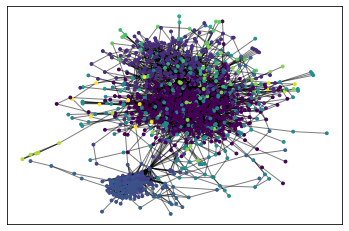

{0: 0,
 1160: 0,
 1167: 7,
 1248: 0,
 1005: 0,
 395: 0,
 1038: 0,
 412: 0,
 707: 0,
 1: 2,
 651: 0,
 375: 0,
 353: 2,
 471: 2,
 2: 3,
 72: 3,
 292: 3,
 966: 3,
 491: 4,
 127: 3,
 781: 3,
 3: 4,
 1202: 4,
 1115: 3,
 940: 4,
 446: 3,
 930: 4,
 351: 4,
 345: 4,
 259: 3,
 1041: 4,
 407: 4,
 973: 4,
 109: 3,
 465: 4,
 802: 4,
 726: 3,
 620: 4,
 122: 3,
 379: 4,
 151: 3,
 1325: 4,
 1056: 4,
 1010: 3,
 896: 4,
 847: 4,
 799: 3,
 773: 3,
 586: 3,
 633: 3,
 481: 4,
 453: 4,
 402: 3,
 394: 4,
 300: 4,
 299: 3,
 173: 3,
 14: 4,
 283: 4,
 964: 4,
 178: 4,
 1138: 3,
 450: 4,
 77: 4,
 810: 4,
 998: 4,
 80: 4,
 1003: 4,
 347: 5,
 1260: 4,
 138: 4,
 469: 3,
 986: 4,
 214: 4,
 41: 4,
 249: 4,
 657: 3,
 748: 4,
 1016: 2,
 96: 4,
 74: 4,
 1267: 6,
 405: 4,
 821: 4,
 1042: 4,
 704: 3,
 895: 4,
 807: 4,
 674: 3,
 1061: 4,
 708: 3,
 359: 3,
 1286: 0,
 392: 4,
 685: 4,
 1111: 4,
 242: 4,
 560: 4,
 882: 4,
 839: 3,
 4: 0,
 1134: 0,
 922: 0,
 5: 7,
 206: 7,
 848: 7,
 90: 7,
 6: 0,
 663: 0,
 793: 0,
 7: 3,
 267

In [41]:
partition1 = community_louvain.best_partition(g)

def drawgraph(g,menberships):# draw the graph
    pos = nx.spring_layout(g)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(menberships.values()) + 1)
    nx.draw_networkx_nodes(g, pos, menberships.keys(), node_size=8,
                           cmap=cmap, node_color=list(menberships.values()))
    nx.draw_networkx_edges(g, pos, alpha=0.5)
    plt.show()
drawgraph(g,partition1)
partition1

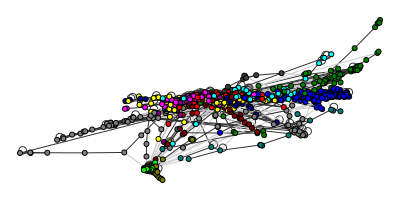

In [42]:
partition2 = la.find_partition(h, la.ModularityVertexPartition)
igraph.plot(partition2,vertex_size=5, bbox=(400,200))

In [43]:
partition3 = community_louvain.best_partition(G)
partition4 = la.find_partition(H, la.ModularityVertexPartition)

In [44]:
print("Cluster number of g:",1+max(partition1.values()))
print("Cluster number of G:",1+max(partition3.values()))

Cluster number of g: 17
Cluster number of G: 16247


In [45]:
igraph.summary(partition2)

Clustering with 1338 elements and 14 clusters


In [46]:
igraph.summary(partition4)

Clustering with 148545 elements and 16284 clusters


In [47]:
print(partition2)

Clustering with 1338 elements and 14 clusters
[ 0] 1, 4, 8, 19, 24, 33, 37, 42, 44, 47, 49, 50, 56, 57, 75, 88, 92, 110,
     119, 125, 126, 129, 150, 154, 158, 160, 170, 176, 189, 197, 201, 203,
     207, 212, 213, 216, 218, 232, 240, 241, 244, 247, 250, 261, 266, 284,
     287, 293, 296, 302, 307, 315, 335, 337, 373, 375, 389, 390, 395, 399,
     410, 417, 418, 420, 429, 435, 438, 448, 457, 463, 466, 470, 483, 485,
     500, 504, 514, 521, 545, 546, 558, 575, 577, 582, 583, 584, 590, 593,
     598, 606, 608, 610, 622, 635, 643, 645, 651, 659, 662, 678, 686, 693,
     695, 705, 714, 715, 723, 724, 731, 732, 744, 757, 760, 763, 768, 769,
     772, 777, 784, 803, 825, 832, 838, 844, 845, 854, 856, 862, 865, 869,
     884, 886, 887, 890, 902, 908, 911, 918, 919, 922, 936, 945, 946, 947,
     956, 959, 963, 967, 979, 990, 992, 996, 999, 1005, 1009, 1011, 1017,
     1023, 1030, 1031, 1045, 1046, 1060, 1065, 1069, 1070, 1077, 1083, 1087,
     1097, 1112, 1122, 1125, 1134, 1143, 1144, 1148, 

In [48]:
def partition_to_list(partition):
    str_p=str(partition)
    strlist = str_p.split('\n')
    a=strlist[1:]
    a=str(a).replace("'",'')
    a=a.replace(",,",",")
    a=a.replace("      ","")
    a=a.replace(", [","\n ")
    a=a.replace("]",",")
    a=a.replace("[","")
    strlist = a.split('\n')
    return strlist
partitionlist2=partition_to_list(partition2)
partitionlist4=partition_to_list(partition4)

In [49]:
partitionlist2

[' 0, 1, 4, 8, 19, 24, 33, 37, 42, 44, 47, 49, 50, 56, 57, 75, 88, 92, 110,119, 125, 126, 129, 150, 154, 158, 160, 170, 176, 189, 197, 201, 203,207, 212, 213, 216, 218, 232, 240, 241, 244, 247, 250, 261, 266, 284,287, 293, 296, 302, 307, 315, 335, 337, 373, 375, 389, 390, 395, 399,410, 417, 418, 420, 429, 435, 438, 448, 457, 463, 466, 470, 483, 485,500, 504, 514, 521, 545, 546, 558, 575, 577, 582, 583, 584, 590, 593,598, 606, 608, 610, 622, 635, 643, 645, 651, 659, 662, 678, 686, 693,695, 705, 714, 715, 723, 724, 731, 732, 744, 757, 760, 763, 768, 769,772, 777, 784, 803, 825, 832, 838, 844, 845, 854, 856, 862, 865, 869,884, 886, 887, 890, 902, 908, 911, 918, 919, 922, 936, 945, 946, 947,956, 959, 963, 967, 979, 990, 992, 996, 999, 1005, 1009, 1011, 1017,1023, 1030, 1031, 1045, 1046, 1060, 1065, 1069, 1070, 1077, 1083, 1087,1097, 1112, 1122, 1125, 1134, 1143, 1144, 1148, 1151, 1157, 1166, 1171,1179, 1194, 1195, 1197, 1201, 1206, 1209, 1216, 1239, 1240, 1253, 1254,1255, 1269, 1272, 1280,

In [50]:
def printpl(partitionlist):
    for pl in partitionlist:
        a=pl.split(',')
        print('There are',len(a)-1,'data with cluster label',a[0])
printpl(partitionlist2)

There are 203 data with cluster label  0
There are 197 data with cluster label   1
There are 172 data with cluster label   2
There are 156 data with cluster label   3
There are 149 data with cluster label   4
There are 102 data with cluster label   5
There are 97 data with cluster label   6
There are 79 data with cluster label   7
There are 77 data with cluster label   8
There are 29 data with cluster label   9
There are 25 data with cluster label  10
There are 20 data with cluster label  11
There are 16 data with cluster label  12
There are 17 data with cluster label  13


In [51]:
printpl(partitionlist4)

There are 11936 data with cluster label     0
There are 11530 data with cluster label      1
There are 10673 data with cluster label      2
There are 8868 data with cluster label      3
There are 7257 data with cluster label      4
There are 5014 data with cluster label      5
There are 4288 data with cluster label      6
There are 3248 data with cluster label      7
There are 3019 data with cluster label      8
There are 2896 data with cluster label      9
There are 2175 data with cluster label     10
There are 2086 data with cluster label     11
There are 1985 data with cluster label     12
There are 1899 data with cluster label     13
There are 1798 data with cluster label     14
There are 1750 data with cluster label     15
There are 1566 data with cluster label     16
There are 1312 data with cluster label     17
There are 1164 data with cluster label     18
There are 1135 data with cluster label     19
There are 1094 data with cluster label     20
There are 1059 data with cluster

There are 8 data with cluster label    390
There are 8 data with cluster label    391
There are 8 data with cluster label    392
There are 8 data with cluster label    393
There are 8 data with cluster label    394
There are 8 data with cluster label    395
There are 8 data with cluster label    396
There are 8 data with cluster label    397
There are 8 data with cluster label    398
There are 8 data with cluster label    399
There are 8 data with cluster label    400
There are 8 data with cluster label    401
There are 8 data with cluster label    402
There are 8 data with cluster label    403
There are 8 data with cluster label    404
There are 8 data with cluster label    405
There are 8 data with cluster label    406
There are 8 data with cluster label    407
There are 8 data with cluster label    408
There are 8 data with cluster label    409
There are 8 data with cluster label    410
There are 8 data with cluster label    411
There are 8 data with cluster label    412
There are 8

There are 6 data with cluster label    764
There are 6 data with cluster label    765
There are 6 data with cluster label    766
There are 6 data with cluster label    767
There are 6 data with cluster label    768
There are 6 data with cluster label    769
There are 6 data with cluster label    770
There are 6 data with cluster label    771
There are 6 data with cluster label    772
There are 6 data with cluster label    773
There are 6 data with cluster label    774
There are 6 data with cluster label    775
There are 6 data with cluster label    776
There are 6 data with cluster label    777
There are 6 data with cluster label    778
There are 6 data with cluster label    779
There are 6 data with cluster label    780
There are 6 data with cluster label    781
There are 6 data with cluster label    782
There are 6 data with cluster label    783
There are 6 data with cluster label    784
There are 6 data with cluster label    785
There are 6 data with cluster label    786
There are 6

There are 4 data with cluster label   1139
There are 4 data with cluster label   1140
There are 4 data with cluster label   1141
There are 4 data with cluster label   1142
There are 4 data with cluster label   1143
There are 4 data with cluster label   1144
There are 4 data with cluster label   1145
There are 4 data with cluster label   1146
There are 4 data with cluster label   1147
There are 4 data with cluster label   1148
There are 4 data with cluster label   1149
There are 4 data with cluster label   1150
There are 4 data with cluster label   1151
There are 4 data with cluster label   1152
There are 4 data with cluster label   1153
There are 4 data with cluster label   1154
There are 4 data with cluster label   1155
There are 4 data with cluster label   1156
There are 4 data with cluster label   1157
There are 4 data with cluster label   1158
There are 4 data with cluster label   1159
There are 4 data with cluster label   1160
There are 4 data with cluster label   1161
There are 4

There are 4 data with cluster label   1514
There are 4 data with cluster label   1515
There are 4 data with cluster label   1516
There are 4 data with cluster label   1517
There are 4 data with cluster label   1518
There are 4 data with cluster label   1519
There are 4 data with cluster label   1520
There are 4 data with cluster label   1521
There are 4 data with cluster label   1522
There are 4 data with cluster label   1523
There are 4 data with cluster label   1524
There are 4 data with cluster label   1525
There are 4 data with cluster label   1526
There are 4 data with cluster label   1527
There are 4 data with cluster label   1528
There are 4 data with cluster label   1529
There are 4 data with cluster label   1530
There are 4 data with cluster label   1531
There are 4 data with cluster label   1532
There are 4 data with cluster label   1533
There are 4 data with cluster label   1534
There are 4 data with cluster label   1535
There are 4 data with cluster label   1536
There are 4

There are 3 data with cluster label   1889
There are 3 data with cluster label   1890
There are 3 data with cluster label   1891
There are 3 data with cluster label   1892
There are 3 data with cluster label   1893
There are 3 data with cluster label   1894
There are 3 data with cluster label   1895
There are 3 data with cluster label   1896
There are 3 data with cluster label   1897
There are 3 data with cluster label   1898
There are 3 data with cluster label   1899
There are 3 data with cluster label   1900
There are 3 data with cluster label   1901
There are 3 data with cluster label   1902
There are 3 data with cluster label   1903
There are 3 data with cluster label   1904
There are 3 data with cluster label   1905
There are 3 data with cluster label   1906
There are 3 data with cluster label   1907
There are 3 data with cluster label   1908
There are 3 data with cluster label   1909
There are 3 data with cluster label   1910
There are 3 data with cluster label   1911
There are 3

There are 3 data with cluster label   2380
There are 3 data with cluster label   2381
There are 3 data with cluster label   2382
There are 3 data with cluster label   2383
There are 3 data with cluster label   2384
There are 3 data with cluster label   2385
There are 3 data with cluster label   2386
There are 3 data with cluster label   2387
There are 3 data with cluster label   2388
There are 3 data with cluster label   2389
There are 3 data with cluster label   2390
There are 3 data with cluster label   2391
There are 3 data with cluster label   2392
There are 3 data with cluster label   2393
There are 3 data with cluster label   2394
There are 3 data with cluster label   2395
There are 3 data with cluster label   2396
There are 3 data with cluster label   2397
There are 3 data with cluster label   2398
There are 3 data with cluster label   2399
There are 3 data with cluster label   2400
There are 3 data with cluster label   2401
There are 3 data with cluster label   2402
There are 3

There are 3 data with cluster label   2672
There are 3 data with cluster label   2673
There are 3 data with cluster label   2674
There are 3 data with cluster label   2675
There are 3 data with cluster label   2676
There are 3 data with cluster label   2677
There are 3 data with cluster label   2678
There are 3 data with cluster label   2679
There are 3 data with cluster label   2680
There are 3 data with cluster label   2681
There are 3 data with cluster label   2682
There are 3 data with cluster label   2683
There are 3 data with cluster label   2684
There are 3 data with cluster label   2685
There are 3 data with cluster label   2686
There are 3 data with cluster label   2687
There are 3 data with cluster label   2688
There are 3 data with cluster label   2689
There are 3 data with cluster label   2690
There are 3 data with cluster label   2691
There are 3 data with cluster label   2692
There are 3 data with cluster label   2693
There are 3 data with cluster label   2694
There are 3

There are 3 data with cluster label   3014
There are 3 data with cluster label   3015
There are 3 data with cluster label   3016
There are 3 data with cluster label   3017
There are 3 data with cluster label   3018
There are 3 data with cluster label   3019
There are 3 data with cluster label   3020
There are 3 data with cluster label   3021
There are 3 data with cluster label   3022
There are 3 data with cluster label   3023
There are 3 data with cluster label   3024
There are 3 data with cluster label   3025
There are 3 data with cluster label   3026
There are 3 data with cluster label   3027
There are 3 data with cluster label   3028
There are 3 data with cluster label   3029
There are 3 data with cluster label   3030
There are 3 data with cluster label   3031
There are 3 data with cluster label   3032
There are 3 data with cluster label   3033
There are 3 data with cluster label   3034
There are 3 data with cluster label   3035
There are 3 data with cluster label   3036
There are 3

There are 3 data with cluster label   3389
There are 3 data with cluster label   3390
There are 3 data with cluster label   3391
There are 3 data with cluster label   3392
There are 3 data with cluster label   3393
There are 3 data with cluster label   3394
There are 3 data with cluster label   3395
There are 3 data with cluster label   3396
There are 3 data with cluster label   3397
There are 3 data with cluster label   3398
There are 3 data with cluster label   3399
There are 3 data with cluster label   3400
There are 3 data with cluster label   3401
There are 3 data with cluster label   3402
There are 3 data with cluster label   3403
There are 3 data with cluster label   3404
There are 3 data with cluster label   3405
There are 3 data with cluster label   3406
There are 3 data with cluster label   3407
There are 3 data with cluster label   3408
There are 3 data with cluster label   3409
There are 3 data with cluster label   3410
There are 3 data with cluster label   3411
There are 3

There are 2 data with cluster label   3796
There are 2 data with cluster label   3797
There are 2 data with cluster label   3798
There are 2 data with cluster label   3799
There are 2 data with cluster label   3800
There are 2 data with cluster label   3801
There are 2 data with cluster label   3802
There are 2 data with cluster label   3803
There are 2 data with cluster label   3804
There are 2 data with cluster label   3805
There are 2 data with cluster label   3806
There are 2 data with cluster label   3807
There are 2 data with cluster label   3808
There are 2 data with cluster label   3809
There are 2 data with cluster label   3810
There are 2 data with cluster label   3811
There are 2 data with cluster label   3812
There are 2 data with cluster label   3813
There are 2 data with cluster label   3814
There are 2 data with cluster label   3815
There are 2 data with cluster label   3816
There are 2 data with cluster label   3817
There are 2 data with cluster label   3818
There are 2

There are 2 data with cluster label   4176
There are 2 data with cluster label   4177
There are 2 data with cluster label   4178
There are 2 data with cluster label   4179
There are 2 data with cluster label   4180
There are 2 data with cluster label   4181
There are 2 data with cluster label   4182
There are 2 data with cluster label   4183
There are 2 data with cluster label   4184
There are 2 data with cluster label   4185
There are 2 data with cluster label   4186
There are 2 data with cluster label   4187
There are 2 data with cluster label   4188
There are 2 data with cluster label   4189
There are 2 data with cluster label   4190
There are 2 data with cluster label   4191
There are 2 data with cluster label   4192
There are 2 data with cluster label   4193
There are 2 data with cluster label   4194
There are 2 data with cluster label   4195
There are 2 data with cluster label   4196
There are 2 data with cluster label   4197
There are 2 data with cluster label   4198
There are 2

There are 2 data with cluster label   4638
There are 2 data with cluster label   4639
There are 2 data with cluster label   4640
There are 2 data with cluster label   4641
There are 2 data with cluster label   4642
There are 2 data with cluster label   4643
There are 2 data with cluster label   4644
There are 2 data with cluster label   4645
There are 2 data with cluster label   4646
There are 2 data with cluster label   4647
There are 2 data with cluster label   4648
There are 2 data with cluster label   4649
There are 2 data with cluster label   4650
There are 2 data with cluster label   4651
There are 2 data with cluster label   4652
There are 2 data with cluster label   4653
There are 2 data with cluster label   4654
There are 2 data with cluster label   4655
There are 2 data with cluster label   4656
There are 2 data with cluster label   4657
There are 2 data with cluster label   4658
There are 2 data with cluster label   4659
There are 2 data with cluster label   4660
There are 2

There are 2 data with cluster label   5013
There are 2 data with cluster label   5014
There are 2 data with cluster label   5015
There are 2 data with cluster label   5016
There are 2 data with cluster label   5017
There are 2 data with cluster label   5018
There are 2 data with cluster label   5019
There are 2 data with cluster label   5020
There are 2 data with cluster label   5021
There are 2 data with cluster label   5022
There are 2 data with cluster label   5023
There are 2 data with cluster label   5024
There are 2 data with cluster label   5025
There are 2 data with cluster label   5026
There are 2 data with cluster label   5027
There are 2 data with cluster label   5028
There are 2 data with cluster label   5029
There are 2 data with cluster label   5030
There are 2 data with cluster label   5031
There are 2 data with cluster label   5032
There are 2 data with cluster label   5033
There are 2 data with cluster label   5034
There are 2 data with cluster label   5035
There are 2

There are 2 data with cluster label   5513
There are 2 data with cluster label   5514
There are 2 data with cluster label   5515
There are 2 data with cluster label   5516
There are 2 data with cluster label   5517
There are 2 data with cluster label   5518
There are 2 data with cluster label   5519
There are 2 data with cluster label   5520
There are 2 data with cluster label   5521
There are 2 data with cluster label   5522
There are 2 data with cluster label   5523
There are 2 data with cluster label   5524
There are 2 data with cluster label   5525
There are 2 data with cluster label   5526
There are 2 data with cluster label   5527
There are 2 data with cluster label   5528
There are 2 data with cluster label   5529
There are 2 data with cluster label   5530
There are 2 data with cluster label   5531
There are 2 data with cluster label   5532
There are 2 data with cluster label   5533
There are 2 data with cluster label   5534
There are 2 data with cluster label   5535
There are 2

There are 2 data with cluster label   5888
There are 2 data with cluster label   5889
There are 2 data with cluster label   5890
There are 2 data with cluster label   5891
There are 2 data with cluster label   5892
There are 2 data with cluster label   5893
There are 2 data with cluster label   5894
There are 2 data with cluster label   5895
There are 2 data with cluster label   5896
There are 2 data with cluster label   5897
There are 2 data with cluster label   5898
There are 2 data with cluster label   5899
There are 2 data with cluster label   5900
There are 2 data with cluster label   5901
There are 2 data with cluster label   5902
There are 2 data with cluster label   5903
There are 2 data with cluster label   5904
There are 2 data with cluster label   5905
There are 2 data with cluster label   5906
There are 2 data with cluster label   5907
There are 2 data with cluster label   5908
There are 2 data with cluster label   5909
There are 2 data with cluster label   5910
There are 2

There are 2 data with cluster label   6388
There are 2 data with cluster label   6389
There are 2 data with cluster label   6390
There are 2 data with cluster label   6391
There are 2 data with cluster label   6392
There are 2 data with cluster label   6393
There are 2 data with cluster label   6394
There are 2 data with cluster label   6395
There are 2 data with cluster label   6396
There are 2 data with cluster label   6397
There are 2 data with cluster label   6398
There are 2 data with cluster label   6399
There are 2 data with cluster label   6400
There are 2 data with cluster label   6401
There are 2 data with cluster label   6402
There are 2 data with cluster label   6403
There are 2 data with cluster label   6404
There are 2 data with cluster label   6405
There are 2 data with cluster label   6406
There are 2 data with cluster label   6407
There are 2 data with cluster label   6408
There are 2 data with cluster label   6409
There are 2 data with cluster label   6410
There are 2

There are 2 data with cluster label   6857
There are 2 data with cluster label   6858
There are 2 data with cluster label   6859
There are 2 data with cluster label   6860
There are 2 data with cluster label   6861
There are 2 data with cluster label   6862
There are 2 data with cluster label   6863
There are 2 data with cluster label   6864
There are 2 data with cluster label   6865
There are 2 data with cluster label   6866
There are 2 data with cluster label   6867
There are 2 data with cluster label   6868
There are 2 data with cluster label   6869
There are 2 data with cluster label   6870
There are 2 data with cluster label   6871
There are 2 data with cluster label   6872
There are 2 data with cluster label   6873
There are 2 data with cluster label   6874
There are 2 data with cluster label   6875
There are 2 data with cluster label   6876
There are 2 data with cluster label   6877
There are 2 data with cluster label   6878
There are 2 data with cluster label   6879
There are 2

There are 2 data with cluster label   7208
There are 2 data with cluster label   7209
There are 2 data with cluster label   7210
There are 2 data with cluster label   7211
There are 2 data with cluster label   7212
There are 2 data with cluster label   7213
There are 2 data with cluster label   7214
There are 2 data with cluster label   7215
There are 2 data with cluster label   7216
There are 2 data with cluster label   7217
There are 2 data with cluster label   7218
There are 2 data with cluster label   7219
There are 2 data with cluster label   7220
There are 2 data with cluster label   7221
There are 2 data with cluster label   7222
There are 2 data with cluster label   7223
There are 2 data with cluster label   7224
There are 2 data with cluster label   7225
There are 2 data with cluster label   7226
There are 2 data with cluster label   7227
There are 2 data with cluster label   7228
There are 2 data with cluster label   7229
There are 2 data with cluster label   7230
There are 2

There are 2 data with cluster label   7637
There are 2 data with cluster label   7638
There are 2 data with cluster label   7639
There are 2 data with cluster label   7640
There are 2 data with cluster label   7641
There are 2 data with cluster label   7642
There are 2 data with cluster label   7643
There are 2 data with cluster label   7644
There are 2 data with cluster label   7645
There are 2 data with cluster label   7646
There are 2 data with cluster label   7647
There are 2 data with cluster label   7648
There are 2 data with cluster label   7649
There are 2 data with cluster label   7650
There are 2 data with cluster label   7651
There are 2 data with cluster label   7652
There are 2 data with cluster label   7653
There are 2 data with cluster label   7654
There are 2 data with cluster label   7655
There are 2 data with cluster label   7656
There are 2 data with cluster label   7657
There are 2 data with cluster label   7658
There are 2 data with cluster label   7659
There are 2

There are 2 data with cluster label   8137
There are 2 data with cluster label   8138
There are 2 data with cluster label   8139
There are 2 data with cluster label   8140
There are 2 data with cluster label   8141
There are 2 data with cluster label   8142
There are 2 data with cluster label   8143
There are 2 data with cluster label   8144
There are 2 data with cluster label   8145
There are 2 data with cluster label   8146
There are 2 data with cluster label   8147
There are 2 data with cluster label   8148
There are 2 data with cluster label   8149
There are 2 data with cluster label   8150
There are 2 data with cluster label   8151
There are 2 data with cluster label   8152
There are 2 data with cluster label   8153
There are 2 data with cluster label   8154
There are 2 data with cluster label   8155
There are 2 data with cluster label   8156
There are 2 data with cluster label   8157
There are 2 data with cluster label   8158
There are 2 data with cluster label   8159
There are 2

There are 2 data with cluster label   8623
There are 2 data with cluster label   8624
There are 2 data with cluster label   8625
There are 2 data with cluster label   8626
There are 2 data with cluster label   8627
There are 2 data with cluster label   8628
There are 2 data with cluster label   8629
There are 2 data with cluster label   8630
There are 2 data with cluster label   8631
There are 2 data with cluster label   8632
There are 2 data with cluster label   8633
There are 2 data with cluster label   8634
There are 2 data with cluster label   8635
There are 2 data with cluster label   8636
There are 2 data with cluster label   8637
There are 2 data with cluster label   8638
There are 2 data with cluster label   8639
There are 2 data with cluster label   8640
There are 2 data with cluster label   8641
There are 2 data with cluster label   8642
There are 2 data with cluster label   8643
There are 2 data with cluster label   8644
There are 2 data with cluster label   8645
There are 2

There are 2 data with cluster label   9012
There are 2 data with cluster label   9013
There are 2 data with cluster label   9014
There are 2 data with cluster label   9015
There are 2 data with cluster label   9016
There are 2 data with cluster label   9017
There are 2 data with cluster label   9018
There are 2 data with cluster label   9019
There are 2 data with cluster label   9020
There are 2 data with cluster label   9021
There are 2 data with cluster label   9022
There are 2 data with cluster label   9023
There are 2 data with cluster label   9024
There are 2 data with cluster label   9025
There are 2 data with cluster label   9026
There are 2 data with cluster label   9027
There are 2 data with cluster label   9028
There are 2 data with cluster label   9029
There are 2 data with cluster label   9030
There are 2 data with cluster label   9031
There are 2 data with cluster label   9032
There are 2 data with cluster label   9033
There are 2 data with cluster label   9034
There are 2

There are 2 data with cluster label   9512
There are 2 data with cluster label   9513
There are 2 data with cluster label   9514
There are 2 data with cluster label   9515
There are 2 data with cluster label   9516
There are 2 data with cluster label   9517
There are 2 data with cluster label   9518
There are 2 data with cluster label   9519
There are 2 data with cluster label   9520
There are 2 data with cluster label   9521
There are 2 data with cluster label   9522
There are 2 data with cluster label   9523
There are 2 data with cluster label   9524
There are 2 data with cluster label   9525
There are 2 data with cluster label   9526
There are 2 data with cluster label   9527
There are 2 data with cluster label   9528
There are 2 data with cluster label   9529
There are 2 data with cluster label   9530
There are 2 data with cluster label   9531
There are 2 data with cluster label   9532
There are 2 data with cluster label   9533
There are 2 data with cluster label   9534
There are 2

There are 2 data with cluster label   9995
There are 2 data with cluster label   9996
There are 2 data with cluster label   9997
There are 2 data with cluster label   9998
There are 2 data with cluster label   9999
There are 2 data with cluster label  10000
There are 2 data with cluster label  10001
There are 2 data with cluster label  10002
There are 2 data with cluster label  10003
There are 2 data with cluster label  10004
There are 2 data with cluster label  10005
There are 2 data with cluster label  10006
There are 2 data with cluster label  10007
There are 2 data with cluster label  10008
There are 2 data with cluster label  10009
There are 2 data with cluster label  10010
There are 2 data with cluster label  10011
There are 2 data with cluster label  10012
There are 2 data with cluster label  10013
There are 2 data with cluster label  10014
There are 2 data with cluster label  10015
There are 2 data with cluster label  10016
There are 2 data with cluster label  10017
There are 2

There are 2 data with cluster label  10262
There are 2 data with cluster label  10263
There are 2 data with cluster label  10264
There are 2 data with cluster label  10265
There are 2 data with cluster label  10266
There are 2 data with cluster label  10267
There are 2 data with cluster label  10268
There are 2 data with cluster label  10269
There are 2 data with cluster label  10270
There are 2 data with cluster label  10271
There are 2 data with cluster label  10272
There are 2 data with cluster label  10273
There are 2 data with cluster label  10274
There are 2 data with cluster label  10275
There are 2 data with cluster label  10276
There are 2 data with cluster label  10277
There are 2 data with cluster label  10278
There are 2 data with cluster label  10279
There are 2 data with cluster label  10280
There are 2 data with cluster label  10281
There are 2 data with cluster label  10282
There are 2 data with cluster label  10283
There are 2 data with cluster label  10284
There are 2

There are 2 data with cluster label  10572
There are 2 data with cluster label  10573
There are 2 data with cluster label  10574
There are 2 data with cluster label  10575
There are 2 data with cluster label  10576
There are 2 data with cluster label  10577
There are 2 data with cluster label  10578
There are 2 data with cluster label  10579
There are 2 data with cluster label  10580
There are 2 data with cluster label  10581
There are 2 data with cluster label  10582
There are 2 data with cluster label  10583
There are 2 data with cluster label  10584
There are 2 data with cluster label  10585
There are 2 data with cluster label  10586
There are 2 data with cluster label  10587
There are 2 data with cluster label  10588
There are 2 data with cluster label  10589
There are 2 data with cluster label  10590
There are 2 data with cluster label  10591
There are 2 data with cluster label  10592
There are 2 data with cluster label  10593
There are 2 data with cluster label  10594
There are 2

There are 2 data with cluster label  10971
There are 2 data with cluster label  10972
There are 2 data with cluster label  10973
There are 2 data with cluster label  10974
There are 2 data with cluster label  10975
There are 2 data with cluster label  10976
There are 2 data with cluster label  10977
There are 2 data with cluster label  10978
There are 2 data with cluster label  10979
There are 2 data with cluster label  10980
There are 2 data with cluster label  10981
There are 2 data with cluster label  10982
There are 2 data with cluster label  10983
There are 2 data with cluster label  10984
There are 2 data with cluster label  10985
There are 2 data with cluster label  10986
There are 2 data with cluster label  10987
There are 2 data with cluster label  10988
There are 2 data with cluster label  10989
There are 2 data with cluster label  10990
There are 2 data with cluster label  10991
There are 2 data with cluster label  10992
There are 2 data with cluster label  10993
There are 2

There are 2 data with cluster label  11261
There are 2 data with cluster label  11262
There are 2 data with cluster label  11263
There are 2 data with cluster label  11264
There are 2 data with cluster label  11265
There are 2 data with cluster label  11266
There are 2 data with cluster label  11267
There are 2 data with cluster label  11268
There are 2 data with cluster label  11269
There are 2 data with cluster label  11270
There are 2 data with cluster label  11271
There are 2 data with cluster label  11272
There are 2 data with cluster label  11273
There are 2 data with cluster label  11274
There are 2 data with cluster label  11275
There are 2 data with cluster label  11276
There are 2 data with cluster label  11277
There are 2 data with cluster label  11278
There are 2 data with cluster label  11279
There are 2 data with cluster label  11280
There are 2 data with cluster label  11281
There are 2 data with cluster label  11282
There are 2 data with cluster label  11283
There are 2

There are 2 data with cluster label  11550
There are 2 data with cluster label  11551
There are 2 data with cluster label  11552
There are 2 data with cluster label  11553
There are 2 data with cluster label  11554
There are 2 data with cluster label  11555
There are 2 data with cluster label  11556
There are 2 data with cluster label  11557
There are 2 data with cluster label  11558
There are 2 data with cluster label  11559
There are 2 data with cluster label  11560
There are 2 data with cluster label  11561
There are 2 data with cluster label  11562
There are 2 data with cluster label  11563
There are 2 data with cluster label  11564
There are 2 data with cluster label  11565
There are 2 data with cluster label  11566
There are 2 data with cluster label  11567
There are 2 data with cluster label  11568
There are 2 data with cluster label  11569
There are 2 data with cluster label  11570
There are 2 data with cluster label  11571
There are 2 data with cluster label  11572
There are 2

There are 2 data with cluster label  11886
There are 2 data with cluster label  11887
There are 2 data with cluster label  11888
There are 2 data with cluster label  11889
There are 2 data with cluster label  11890
There are 2 data with cluster label  11891
There are 2 data with cluster label  11892
There are 2 data with cluster label  11893
There are 2 data with cluster label  11894
There are 2 data with cluster label  11895
There are 2 data with cluster label  11896
There are 2 data with cluster label  11897
There are 2 data with cluster label  11898
There are 2 data with cluster label  11899
There are 2 data with cluster label  11900
There are 2 data with cluster label  11901
There are 2 data with cluster label  11902
There are 2 data with cluster label  11903
There are 2 data with cluster label  11904
There are 2 data with cluster label  11905
There are 2 data with cluster label  11906
There are 2 data with cluster label  11907
There are 2 data with cluster label  11908
There are 2

There are 2 data with cluster label  12289
There are 2 data with cluster label  12290
There are 2 data with cluster label  12291
There are 2 data with cluster label  12292
There are 2 data with cluster label  12293
There are 2 data with cluster label  12294
There are 2 data with cluster label  12295
There are 2 data with cluster label  12296
There are 2 data with cluster label  12297
There are 2 data with cluster label  12298
There are 2 data with cluster label  12299
There are 2 data with cluster label  12300
There are 2 data with cluster label  12301
There are 2 data with cluster label  12302
There are 2 data with cluster label  12303
There are 2 data with cluster label  12304
There are 2 data with cluster label  12305
There are 2 data with cluster label  12306
There are 2 data with cluster label  12307
There are 2 data with cluster label  12308
There are 2 data with cluster label  12309
There are 2 data with cluster label  12310
There are 2 data with cluster label  12311
There are 2

There are 2 data with cluster label  12761
There are 2 data with cluster label  12762
There are 2 data with cluster label  12763
There are 2 data with cluster label  12764
There are 2 data with cluster label  12765
There are 2 data with cluster label  12766
There are 2 data with cluster label  12767
There are 2 data with cluster label  12768
There are 2 data with cluster label  12769
There are 2 data with cluster label  12770
There are 2 data with cluster label  12771
There are 2 data with cluster label  12772
There are 2 data with cluster label  12773
There are 2 data with cluster label  12774
There are 2 data with cluster label  12775
There are 2 data with cluster label  12776
There are 2 data with cluster label  12777
There are 2 data with cluster label  12778
There are 2 data with cluster label  12779
There are 2 data with cluster label  12780
There are 2 data with cluster label  12781
There are 2 data with cluster label  12782
There are 2 data with cluster label  12783
There are 2

There are 2 data with cluster label  13173
There are 2 data with cluster label  13174
There are 2 data with cluster label  13175
There are 2 data with cluster label  13176
There are 2 data with cluster label  13177
There are 2 data with cluster label  13178
There are 2 data with cluster label  13179
There are 2 data with cluster label  13180
There are 2 data with cluster label  13181
There are 2 data with cluster label  13182
There are 2 data with cluster label  13183
There are 2 data with cluster label  13184
There are 2 data with cluster label  13185
There are 2 data with cluster label  13186
There are 2 data with cluster label  13187
There are 2 data with cluster label  13188
There are 2 data with cluster label  13189
There are 2 data with cluster label  13190
There are 2 data with cluster label  13191
There are 2 data with cluster label  13192
There are 2 data with cluster label  13193
There are 2 data with cluster label  13194
There are 2 data with cluster label  13195
There are 2

There are 2 data with cluster label  13633
There are 2 data with cluster label  13634
There are 2 data with cluster label  13635
There are 2 data with cluster label  13636
There are 2 data with cluster label  13637
There are 2 data with cluster label  13638
There are 2 data with cluster label  13639
There are 2 data with cluster label  13640
There are 2 data with cluster label  13641
There are 2 data with cluster label  13642
There are 2 data with cluster label  13643
There are 2 data with cluster label  13644
There are 2 data with cluster label  13645
There are 2 data with cluster label  13646
There are 2 data with cluster label  13647
There are 2 data with cluster label  13648
There are 2 data with cluster label  13649
There are 2 data with cluster label  13650
There are 2 data with cluster label  13651
There are 2 data with cluster label  13652
There are 2 data with cluster label  13653
There are 2 data with cluster label  13654
There are 2 data with cluster label  13655
There are 2

There are 2 data with cluster label  14010
There are 2 data with cluster label  14011
There are 2 data with cluster label  14012
There are 2 data with cluster label  14013
There are 2 data with cluster label  14014
There are 2 data with cluster label  14015
There are 2 data with cluster label  14016
There are 2 data with cluster label  14017
There are 2 data with cluster label  14018
There are 2 data with cluster label  14019
There are 2 data with cluster label  14020
There are 2 data with cluster label  14021
There are 2 data with cluster label  14022
There are 2 data with cluster label  14023
There are 2 data with cluster label  14024
There are 2 data with cluster label  14025
There are 2 data with cluster label  14026
There are 2 data with cluster label  14027
There are 2 data with cluster label  14028
There are 2 data with cluster label  14029
There are 2 data with cluster label  14030
There are 2 data with cluster label  14031
There are 2 data with cluster label  14032
There are 2

There are 2 data with cluster label  14510
There are 2 data with cluster label  14511
There are 2 data with cluster label  14512
There are 2 data with cluster label  14513
There are 2 data with cluster label  14514
There are 2 data with cluster label  14515
There are 2 data with cluster label  14516
There are 2 data with cluster label  14517
There are 2 data with cluster label  14518
There are 2 data with cluster label  14519
There are 2 data with cluster label  14520
There are 2 data with cluster label  14521
There are 2 data with cluster label  14522
There are 2 data with cluster label  14523
There are 2 data with cluster label  14524
There are 2 data with cluster label  14525
There are 2 data with cluster label  14526
There are 2 data with cluster label  14527
There are 2 data with cluster label  14528
There are 2 data with cluster label  14529
There are 2 data with cluster label  14530
There are 2 data with cluster label  14531
There are 2 data with cluster label  14532
There are 2

There are 2 data with cluster label  15010
There are 2 data with cluster label  15011
There are 2 data with cluster label  15012
There are 2 data with cluster label  15013
There are 2 data with cluster label  15014
There are 2 data with cluster label  15015
There are 2 data with cluster label  15016
There are 2 data with cluster label  15017
There are 2 data with cluster label  15018
There are 2 data with cluster label  15019
There are 2 data with cluster label  15020
There are 2 data with cluster label  15021
There are 2 data with cluster label  15022
There are 2 data with cluster label  15023
There are 2 data with cluster label  15024
There are 2 data with cluster label  15025
There are 2 data with cluster label  15026
There are 2 data with cluster label  15027
There are 2 data with cluster label  15028
There are 2 data with cluster label  15029
There are 2 data with cluster label  15030
There are 2 data with cluster label  15031
There are 2 data with cluster label  15032
There are 2

There are 1 data with cluster label  15385
There are 1 data with cluster label  15386
There are 1 data with cluster label  15387
There are 1 data with cluster label  15388
There are 1 data with cluster label  15389
There are 1 data with cluster label  15390
There are 1 data with cluster label  15391
There are 1 data with cluster label  15392
There are 1 data with cluster label  15393
There are 1 data with cluster label  15394
There are 1 data with cluster label  15395
There are 1 data with cluster label  15396
There are 1 data with cluster label  15397
There are 1 data with cluster label  15398
There are 1 data with cluster label  15399
There are 1 data with cluster label  15400
There are 1 data with cluster label  15401
There are 1 data with cluster label  15402
There are 1 data with cluster label  15403
There are 1 data with cluster label  15404
There are 1 data with cluster label  15405
There are 1 data with cluster label  15406
There are 1 data with cluster label  15407
There are 1

There are 1 data with cluster label  15817
There are 1 data with cluster label  15818
There are 1 data with cluster label  15819
There are 1 data with cluster label  15820
There are 1 data with cluster label  15821
There are 1 data with cluster label  15822
There are 1 data with cluster label  15823
There are 1 data with cluster label  15824
There are 1 data with cluster label  15825
There are 1 data with cluster label  15826
There are 1 data with cluster label  15827
There are 1 data with cluster label  15828
There are 1 data with cluster label  15829
There are 1 data with cluster label  15830
There are 1 data with cluster label  15831
There are 1 data with cluster label  15832
There are 1 data with cluster label  15833
There are 1 data with cluster label  15834
There are 1 data with cluster label  15835
There are 1 data with cluster label  15836
There are 1 data with cluster label  15837
There are 1 data with cluster label  15838
There are 1 data with cluster label  15839
There are 1

There are 1 data with cluster label  16260
There are 1 data with cluster label  16261
There are 1 data with cluster label  16262
There are 1 data with cluster label  16263
There are 1 data with cluster label  16264
There are 1 data with cluster label  16265
There are 1 data with cluster label  16266
There are 1 data with cluster label  16267
There are 1 data with cluster label  16268
There are 1 data with cluster label  16269
There are 1 data with cluster label  16270
There are 1 data with cluster label  16271
There are 1 data with cluster label  16272
There are 1 data with cluster label  16273
There are 1 data with cluster label  16274
There are 1 data with cluster label  16275
There are 1 data with cluster label  16276
There are 1 data with cluster label  16277
There are 1 data with cluster label  16278
There are 1 data with cluster label  16279
There are 1 data with cluster label  16280
There are 1 data with cluster label  16281
There are 1 data with cluster label  16282
There are 2

In [52]:
def partitionlist_print(partition):
    partitionlist=[]
    for i in range(1+max(partition.values())):
        pl=[k for k,v in partition.items() if v == i]
        print('There are',len(pl),'data with cluster label',i)
        partitionlist.append(pl)
    return partitionlist
partitionlist_print(partition1)


There are 525 data with cluster label 0
There are 8 data with cluster label 1
There are 264 data with cluster label 2
There are 71 data with cluster label 3
There are 131 data with cluster label 4
There are 51 data with cluster label 5
There are 1 data with cluster label 6
There are 119 data with cluster label 7
There are 51 data with cluster label 8
There are 5 data with cluster label 9
There are 23 data with cluster label 10
There are 14 data with cluster label 11
There are 23 data with cluster label 12
There are 33 data with cluster label 13
There are 6 data with cluster label 14
There are 4 data with cluster label 15
There are 9 data with cluster label 16


[[0,
  1160,
  1248,
  1005,
  395,
  1038,
  412,
  707,
  651,
  375,
  1286,
  4,
  1134,
  922,
  6,
  663,
  793,
  8,
  160,
  9,
  864,
  97,
  10,
  760,
  11,
  534,
  13,
  913,
  15,
  967,
  322,
  787,
  474,
  16,
  851,
  161,
  17,
  1275,
  1219,
  695,
  1112,
  137,
  514,
  18,
  759,
  808,
  19,
  250,
  50,
  558,
  744,
  1269,
  294,
  22,
  739,
  452,
  953,
  24,
  197,
  886,
  29,
  113,
  30,
  1012,
  675,
  33,
  287,
  37,
  1060,
  575,
  1321,
  132,
  622,
  40,
  253,
  169,
  42,
  389,
  686,
  418,
  43,
  613,
  44,
  461,
  218,
  1179,
  1206,
  45,
  929,
  844,
  108,
  47,
  410,
  88,
  1122,
  545,
  420,
  1237,
  645,
  1157,
  643,
  1337,
  457,
  1150,
  54,
  498,
  56,
  1201,
  57,
  1254,
  1104,
  1166,
  1123,
  902,
  1280,
  149,
  62,
  894,
  487,
  941,
  404,
  980,
  235,
  631,
  75,
  519,
  79,
  478,
  81,
  551,
  511,
  510,
  272,
  580,
  1143,
  515,
  83,
  752,
  268,
  901,
  87,
  1264,
  1036,
  947,
  872

In [53]:
partitionlist_print(partition3)

There are 2 data with cluster label 0
There are 7 data with cluster label 1
There are 3 data with cluster label 2
There are 4680 data with cluster label 3
There are 6828 data with cluster label 4
There are 1558 data with cluster label 5
There are 382 data with cluster label 6
There are 3 data with cluster label 7
There are 3 data with cluster label 8
There are 11573 data with cluster label 9
There are 3 data with cluster label 10
There are 455 data with cluster label 11
There are 7 data with cluster label 12
There are 6972 data with cluster label 13
There are 448 data with cluster label 14
There are 2668 data with cluster label 15
There are 2 data with cluster label 16
There are 12153 data with cluster label 17
There are 3 data with cluster label 18
There are 4408 data with cluster label 19
There are 1467 data with cluster label 20
There are 11936 data with cluster label 21
There are 2065 data with cluster label 22
There are 1935 data with cluster label 23
There are 390 data with clust

There are 66 data with cluster label 214
There are 4 data with cluster label 215
There are 2 data with cluster label 216
There are 11 data with cluster label 217
There are 13 data with cluster label 218
There are 6 data with cluster label 219
There are 781 data with cluster label 220
There are 10 data with cluster label 221
There are 3 data with cluster label 222
There are 2 data with cluster label 223
There are 1 data with cluster label 224
There are 2 data with cluster label 225
There are 2 data with cluster label 226
There are 2 data with cluster label 227
There are 2 data with cluster label 228
There are 4 data with cluster label 229
There are 1 data with cluster label 230
There are 2 data with cluster label 231
There are 1 data with cluster label 232
There are 3 data with cluster label 233
There are 3 data with cluster label 234
There are 2 data with cluster label 235
There are 2 data with cluster label 236
There are 2 data with cluster label 237
There are 4 data with cluster labe

There are 135 data with cluster label 434
There are 3 data with cluster label 435
There are 6 data with cluster label 436
There are 3 data with cluster label 437
There are 6 data with cluster label 438
There are 2 data with cluster label 439
There are 4 data with cluster label 440
There are 337 data with cluster label 441
There are 7 data with cluster label 442
There are 4 data with cluster label 443
There are 2 data with cluster label 444
There are 4 data with cluster label 445
There are 22 data with cluster label 446
There are 2 data with cluster label 447
There are 2 data with cluster label 448
There are 7 data with cluster label 449
There are 6 data with cluster label 450
There are 2 data with cluster label 451
There are 10 data with cluster label 452
There are 2 data with cluster label 453
There are 2 data with cluster label 454
There are 3 data with cluster label 455
There are 2 data with cluster label 456
There are 2 data with cluster label 457
There are 15 data with cluster lab

There are 2 data with cluster label 651
There are 2 data with cluster label 652
There are 5 data with cluster label 653
There are 2 data with cluster label 654
There are 2 data with cluster label 655
There are 2 data with cluster label 656
There are 11 data with cluster label 657
There are 2 data with cluster label 658
There are 2 data with cluster label 659
There are 2 data with cluster label 660
There are 3 data with cluster label 661
There are 2 data with cluster label 662
There are 2 data with cluster label 663
There are 2 data with cluster label 664
There are 2 data with cluster label 665
There are 11 data with cluster label 666
There are 3 data with cluster label 667
There are 3 data with cluster label 668
There are 9 data with cluster label 669
There are 2 data with cluster label 670
There are 19 data with cluster label 671
There are 3 data with cluster label 672
There are 46 data with cluster label 673
There are 6 data with cluster label 674
There are 1 data with cluster label 

There are 2 data with cluster label 869
There are 4 data with cluster label 870
There are 1 data with cluster label 871
There are 1 data with cluster label 872
There are 2 data with cluster label 873
There are 3 data with cluster label 874
There are 7 data with cluster label 875
There are 2 data with cluster label 876
There are 2 data with cluster label 877
There are 1 data with cluster label 878
There are 3 data with cluster label 879
There are 3 data with cluster label 880
There are 6 data with cluster label 881
There are 5 data with cluster label 882
There are 4 data with cluster label 883
There are 2 data with cluster label 884
There are 3 data with cluster label 885
There are 2 data with cluster label 886
There are 2 data with cluster label 887
There are 5 data with cluster label 888
There are 2 data with cluster label 889
There are 2 data with cluster label 890
There are 2 data with cluster label 891
There are 2 data with cluster label 892
There are 2 data with cluster label 893


There are 2 data with cluster label 1086
There are 2 data with cluster label 1087
There are 2 data with cluster label 1088
There are 4 data with cluster label 1089
There are 3 data with cluster label 1090
There are 2 data with cluster label 1091
There are 2 data with cluster label 1092
There are 2 data with cluster label 1093
There are 4 data with cluster label 1094
There are 2 data with cluster label 1095
There are 2 data with cluster label 1096
There are 2 data with cluster label 1097
There are 3 data with cluster label 1098
There are 2 data with cluster label 1099
There are 2 data with cluster label 1100
There are 2 data with cluster label 1101
There are 3 data with cluster label 1102
There are 1 data with cluster label 1103
There are 2 data with cluster label 1104
There are 2 data with cluster label 1105
There are 3 data with cluster label 1106
There are 2 data with cluster label 1107
There are 5 data with cluster label 1108
There are 2 data with cluster label 1109
There are 2 data

There are 2 data with cluster label 1302
There are 3 data with cluster label 1303
There are 2 data with cluster label 1304
There are 2 data with cluster label 1305
There are 2 data with cluster label 1306
There are 2 data with cluster label 1307
There are 5 data with cluster label 1308
There are 2 data with cluster label 1309
There are 2 data with cluster label 1310
There are 2 data with cluster label 1311
There are 1 data with cluster label 1312
There are 2 data with cluster label 1313
There are 3 data with cluster label 1314
There are 9 data with cluster label 1315
There are 2 data with cluster label 1316
There are 2 data with cluster label 1317
There are 2 data with cluster label 1318
There are 3 data with cluster label 1319
There are 2 data with cluster label 1320
There are 2 data with cluster label 1321
There are 2 data with cluster label 1322
There are 3 data with cluster label 1323
There are 2 data with cluster label 1324
There are 2 data with cluster label 1325
There are 2 data

There are 3 data with cluster label 1518
There are 3 data with cluster label 1519
There are 12 data with cluster label 1520
There are 3 data with cluster label 1521
There are 2 data with cluster label 1522
There are 4 data with cluster label 1523
There are 2 data with cluster label 1524
There are 3 data with cluster label 1525
There are 2 data with cluster label 1526
There are 18 data with cluster label 1527
There are 2 data with cluster label 1528
There are 2 data with cluster label 1529
There are 2 data with cluster label 1530
There are 3 data with cluster label 1531
There are 2 data with cluster label 1532
There are 2 data with cluster label 1533
There are 2 data with cluster label 1534
There are 2 data with cluster label 1535
There are 5 data with cluster label 1536
There are 2 data with cluster label 1537
There are 8 data with cluster label 1538
There are 21 data with cluster label 1539
There are 5 data with cluster label 1540
There are 1 data with cluster label 1541
There are 2 d

There are 4 data with cluster label 1739
There are 4 data with cluster label 1740
There are 2 data with cluster label 1741
There are 2 data with cluster label 1742
There are 2 data with cluster label 1743
There are 2 data with cluster label 1744
There are 2 data with cluster label 1745
There are 2 data with cluster label 1746
There are 3 data with cluster label 1747
There are 2 data with cluster label 1748
There are 5 data with cluster label 1749
There are 2 data with cluster label 1750
There are 2 data with cluster label 1751
There are 4 data with cluster label 1752
There are 4 data with cluster label 1753
There are 4 data with cluster label 1754
There are 2 data with cluster label 1755
There are 5 data with cluster label 1756
There are 2 data with cluster label 1757
There are 2 data with cluster label 1758
There are 2 data with cluster label 1759
There are 3 data with cluster label 1760
There are 2 data with cluster label 1761
There are 7 data with cluster label 1762
There are 15 dat

There are 11 data with cluster label 1958
There are 6 data with cluster label 1959
There are 2 data with cluster label 1960
There are 5 data with cluster label 1961
There are 2 data with cluster label 1962
There are 1 data with cluster label 1963
There are 4 data with cluster label 1964
There are 3 data with cluster label 1965
There are 4 data with cluster label 1966
There are 2 data with cluster label 1967
There are 2 data with cluster label 1968
There are 2 data with cluster label 1969
There are 4 data with cluster label 1970
There are 7 data with cluster label 1971
There are 2 data with cluster label 1972
There are 1 data with cluster label 1973
There are 5 data with cluster label 1974
There are 2 data with cluster label 1975
There are 2 data with cluster label 1976
There are 2 data with cluster label 1977
There are 4 data with cluster label 1978
There are 4 data with cluster label 1979
There are 2 data with cluster label 1980
There are 2 data with cluster label 1981
There are 2 dat

There are 2 data with cluster label 2170
There are 2 data with cluster label 2171
There are 4 data with cluster label 2172
There are 3 data with cluster label 2173
There are 1 data with cluster label 2174
There are 2 data with cluster label 2175
There are 2 data with cluster label 2176
There are 1 data with cluster label 2177
There are 4 data with cluster label 2178
There are 3 data with cluster label 2179
There are 2 data with cluster label 2180
There are 2 data with cluster label 2181
There are 1 data with cluster label 2182
There are 4 data with cluster label 2183
There are 6 data with cluster label 2184
There are 11 data with cluster label 2185
There are 2 data with cluster label 2186
There are 2 data with cluster label 2187
There are 2 data with cluster label 2188
There are 2 data with cluster label 2189
There are 2 data with cluster label 2190
There are 2 data with cluster label 2191
There are 2 data with cluster label 2192
There are 2 data with cluster label 2193
There are 3 dat

There are 4 data with cluster label 2385
There are 2 data with cluster label 2386
There are 2 data with cluster label 2387
There are 2 data with cluster label 2388
There are 2 data with cluster label 2389
There are 4 data with cluster label 2390
There are 3 data with cluster label 2391
There are 5 data with cluster label 2392
There are 1 data with cluster label 2393
There are 4 data with cluster label 2394
There are 2 data with cluster label 2395
There are 1 data with cluster label 2396
There are 2 data with cluster label 2397
There are 2 data with cluster label 2398
There are 2 data with cluster label 2399
There are 2 data with cluster label 2400
There are 2 data with cluster label 2401
There are 6 data with cluster label 2402
There are 2 data with cluster label 2403
There are 2 data with cluster label 2404
There are 10 data with cluster label 2405
There are 2 data with cluster label 2406
There are 8 data with cluster label 2407
There are 2 data with cluster label 2408
There are 3 dat

There are 2 data with cluster label 2603
There are 3 data with cluster label 2604
There are 2 data with cluster label 2605
There are 1 data with cluster label 2606
There are 3 data with cluster label 2607
There are 6 data with cluster label 2608
There are 2 data with cluster label 2609
There are 2 data with cluster label 2610
There are 2 data with cluster label 2611
There are 2 data with cluster label 2612
There are 4 data with cluster label 2613
There are 2 data with cluster label 2614
There are 2 data with cluster label 2615
There are 1 data with cluster label 2616
There are 1 data with cluster label 2617
There are 4 data with cluster label 2618
There are 2 data with cluster label 2619
There are 16 data with cluster label 2620
There are 2 data with cluster label 2621
There are 2 data with cluster label 2622
There are 1 data with cluster label 2623
There are 2 data with cluster label 2624
There are 1 data with cluster label 2625
There are 2 data with cluster label 2626
There are 4 dat

There are 3 data with cluster label 2822
There are 2 data with cluster label 2823
There are 4 data with cluster label 2824
There are 2 data with cluster label 2825
There are 2 data with cluster label 2826
There are 7 data with cluster label 2827
There are 8 data with cluster label 2828
There are 2 data with cluster label 2829
There are 3 data with cluster label 2830
There are 2 data with cluster label 2831
There are 2 data with cluster label 2832
There are 2 data with cluster label 2833
There are 2 data with cluster label 2834
There are 2 data with cluster label 2835
There are 2 data with cluster label 2836
There are 31 data with cluster label 2837
There are 2 data with cluster label 2838
There are 2 data with cluster label 2839
There are 2 data with cluster label 2840
There are 6 data with cluster label 2841
There are 2 data with cluster label 2842
There are 2 data with cluster label 2843
There are 2 data with cluster label 2844
There are 1 data with cluster label 2845
There are 3 dat

There are 3 data with cluster label 3043
There are 10 data with cluster label 3044
There are 2 data with cluster label 3045
There are 2 data with cluster label 3046
There are 2 data with cluster label 3047
There are 4 data with cluster label 3048
There are 4 data with cluster label 3049
There are 2 data with cluster label 3050
There are 2 data with cluster label 3051
There are 3 data with cluster label 3052
There are 2 data with cluster label 3053
There are 2 data with cluster label 3054
There are 3 data with cluster label 3055
There are 2 data with cluster label 3056
There are 2 data with cluster label 3057
There are 1 data with cluster label 3058
There are 4 data with cluster label 3059
There are 2 data with cluster label 3060
There are 2 data with cluster label 3061
There are 2 data with cluster label 3062
There are 2 data with cluster label 3063
There are 2 data with cluster label 3064
There are 2 data with cluster label 3065
There are 3 data with cluster label 3066
There are 2 dat

There are 2 data with cluster label 3260
There are 2 data with cluster label 3261
There are 5 data with cluster label 3262
There are 4 data with cluster label 3263
There are 2 data with cluster label 3264
There are 7 data with cluster label 3265
There are 1 data with cluster label 3266
There are 5 data with cluster label 3267
There are 2 data with cluster label 3268
There are 4 data with cluster label 3269
There are 3 data with cluster label 3270
There are 2 data with cluster label 3271
There are 2 data with cluster label 3272
There are 3 data with cluster label 3273
There are 4 data with cluster label 3274
There are 2 data with cluster label 3275
There are 1 data with cluster label 3276
There are 2 data with cluster label 3277
There are 1 data with cluster label 3278
There are 2 data with cluster label 3279
There are 2 data with cluster label 3280
There are 2 data with cluster label 3281
There are 2 data with cluster label 3282
There are 9 data with cluster label 3283
There are 2 data

There are 2 data with cluster label 3479
There are 1 data with cluster label 3480
There are 10 data with cluster label 3481
There are 5 data with cluster label 3482
There are 2 data with cluster label 3483
There are 2 data with cluster label 3484
There are 3 data with cluster label 3485
There are 5 data with cluster label 3486
There are 3 data with cluster label 3487
There are 2 data with cluster label 3488
There are 2 data with cluster label 3489
There are 2 data with cluster label 3490
There are 2 data with cluster label 3491
There are 3 data with cluster label 3492
There are 3 data with cluster label 3493
There are 2 data with cluster label 3494
There are 3 data with cluster label 3495
There are 1 data with cluster label 3496
There are 3 data with cluster label 3497
There are 2 data with cluster label 3498
There are 2 data with cluster label 3499
There are 2 data with cluster label 3500
There are 2 data with cluster label 3501
There are 4 data with cluster label 3502
There are 3 dat

There are 2 data with cluster label 3700
There are 4 data with cluster label 3701
There are 1 data with cluster label 3702
There are 4 data with cluster label 3703
There are 2 data with cluster label 3704
There are 1 data with cluster label 3705
There are 2 data with cluster label 3706
There are 2 data with cluster label 3707
There are 2 data with cluster label 3708
There are 2 data with cluster label 3709
There are 18 data with cluster label 3710
There are 2 data with cluster label 3711
There are 4 data with cluster label 3712
There are 2 data with cluster label 3713
There are 2 data with cluster label 3714
There are 2 data with cluster label 3715
There are 4 data with cluster label 3716
There are 2 data with cluster label 3717
There are 2 data with cluster label 3718
There are 2 data with cluster label 3719
There are 2 data with cluster label 3720
There are 2 data with cluster label 3721
There are 2 data with cluster label 3722
There are 3 data with cluster label 3723
There are 2 dat

There are 2 data with cluster label 3921
There are 2 data with cluster label 3922
There are 2 data with cluster label 3923
There are 2 data with cluster label 3924
There are 2 data with cluster label 3925
There are 3 data with cluster label 3926
There are 2 data with cluster label 3927
There are 3 data with cluster label 3928
There are 3 data with cluster label 3929
There are 2 data with cluster label 3930
There are 13 data with cluster label 3931
There are 3 data with cluster label 3932
There are 2 data with cluster label 3933
There are 2 data with cluster label 3934
There are 2 data with cluster label 3935
There are 2 data with cluster label 3936
There are 2 data with cluster label 3937
There are 2 data with cluster label 3938
There are 2 data with cluster label 3939
There are 4 data with cluster label 3940
There are 6 data with cluster label 3941
There are 3 data with cluster label 3942
There are 3 data with cluster label 3943
There are 2 data with cluster label 3944
There are 4 dat

There are 2 data with cluster label 4142
There are 4 data with cluster label 4143
There are 2 data with cluster label 4144
There are 2 data with cluster label 4145
There are 2 data with cluster label 4146
There are 2 data with cluster label 4147
There are 2 data with cluster label 4148
There are 14 data with cluster label 4149
There are 2 data with cluster label 4150
There are 2 data with cluster label 4151
There are 3 data with cluster label 4152
There are 2 data with cluster label 4153
There are 2 data with cluster label 4154
There are 3 data with cluster label 4155
There are 2 data with cluster label 4156
There are 2 data with cluster label 4157
There are 2 data with cluster label 4158
There are 3 data with cluster label 4159
There are 5 data with cluster label 4160
There are 4 data with cluster label 4161
There are 6 data with cluster label 4162
There are 5 data with cluster label 4163
There are 2 data with cluster label 4164
There are 3 data with cluster label 4165
There are 4 dat

There are 2 data with cluster label 4360
There are 3 data with cluster label 4361
There are 2 data with cluster label 4362
There are 2 data with cluster label 4363
There are 2 data with cluster label 4364
There are 3 data with cluster label 4365
There are 2 data with cluster label 4366
There are 3 data with cluster label 4367
There are 2 data with cluster label 4368
There are 3 data with cluster label 4369
There are 3 data with cluster label 4370
There are 2 data with cluster label 4371
There are 2 data with cluster label 4372
There are 2 data with cluster label 4373
There are 5 data with cluster label 4374
There are 2 data with cluster label 4375
There are 2 data with cluster label 4376
There are 2 data with cluster label 4377
There are 3 data with cluster label 4378
There are 2 data with cluster label 4379
There are 2 data with cluster label 4380
There are 2 data with cluster label 4381
There are 1 data with cluster label 4382
There are 2 data with cluster label 4383
There are 2 data

There are 2 data with cluster label 4580
There are 2 data with cluster label 4581
There are 2 data with cluster label 4582
There are 2 data with cluster label 4583
There are 2 data with cluster label 4584
There are 2 data with cluster label 4585
There are 8 data with cluster label 4586
There are 2 data with cluster label 4587
There are 2 data with cluster label 4588
There are 1 data with cluster label 4589
There are 2 data with cluster label 4590
There are 3 data with cluster label 4591
There are 3 data with cluster label 4592
There are 2 data with cluster label 4593
There are 2 data with cluster label 4594
There are 3 data with cluster label 4595
There are 3 data with cluster label 4596
There are 2 data with cluster label 4597
There are 2 data with cluster label 4598
There are 2 data with cluster label 4599
There are 3 data with cluster label 4600
There are 2 data with cluster label 4601
There are 1 data with cluster label 4602
There are 4 data with cluster label 4603
There are 2 data

There are 6 data with cluster label 4802
There are 2 data with cluster label 4803
There are 5 data with cluster label 4804
There are 5 data with cluster label 4805
There are 2 data with cluster label 4806
There are 2 data with cluster label 4807
There are 2 data with cluster label 4808
There are 4 data with cluster label 4809
There are 1 data with cluster label 4810
There are 2 data with cluster label 4811
There are 2 data with cluster label 4812
There are 3 data with cluster label 4813
There are 3 data with cluster label 4814
There are 2 data with cluster label 4815
There are 2 data with cluster label 4816
There are 3 data with cluster label 4817
There are 10 data with cluster label 4818
There are 2 data with cluster label 4819
There are 4 data with cluster label 4820
There are 2 data with cluster label 4821
There are 3 data with cluster label 4822
There are 2 data with cluster label 4823
There are 2 data with cluster label 4824
There are 3 data with cluster label 4825
There are 2 dat

There are 2 data with cluster label 5024
There are 2 data with cluster label 5025
There are 8 data with cluster label 5026
There are 2 data with cluster label 5027
There are 2 data with cluster label 5028
There are 2 data with cluster label 5029
There are 2 data with cluster label 5030
There are 3 data with cluster label 5031
There are 2 data with cluster label 5032
There are 2 data with cluster label 5033
There are 2 data with cluster label 5034
There are 2 data with cluster label 5035
There are 2 data with cluster label 5036
There are 3 data with cluster label 5037
There are 2 data with cluster label 5038
There are 2 data with cluster label 5039
There are 2 data with cluster label 5040
There are 3 data with cluster label 5041
There are 3 data with cluster label 5042
There are 1 data with cluster label 5043
There are 3 data with cluster label 5044
There are 2 data with cluster label 5045
There are 2 data with cluster label 5046
There are 3 data with cluster label 5047
There are 3 data

There are 2 data with cluster label 5240
There are 3 data with cluster label 5241
There are 1 data with cluster label 5242
There are 6 data with cluster label 5243
There are 2 data with cluster label 5244
There are 2 data with cluster label 5245
There are 3 data with cluster label 5246
There are 2 data with cluster label 5247
There are 2 data with cluster label 5248
There are 2 data with cluster label 5249
There are 5 data with cluster label 5250
There are 1 data with cluster label 5251
There are 2 data with cluster label 5252
There are 3 data with cluster label 5253
There are 2 data with cluster label 5254
There are 4 data with cluster label 5255
There are 2 data with cluster label 5256
There are 2 data with cluster label 5257
There are 3 data with cluster label 5258
There are 2 data with cluster label 5259
There are 2 data with cluster label 5260
There are 2 data with cluster label 5261
There are 2 data with cluster label 5262
There are 2 data with cluster label 5263
There are 2 data

There are 1 data with cluster label 5458
There are 2 data with cluster label 5459
There are 6 data with cluster label 5460
There are 2 data with cluster label 5461
There are 2 data with cluster label 5462
There are 2 data with cluster label 5463
There are 3 data with cluster label 5464
There are 2 data with cluster label 5465
There are 2 data with cluster label 5466
There are 2 data with cluster label 5467
There are 3 data with cluster label 5468
There are 1 data with cluster label 5469
There are 2 data with cluster label 5470
There are 6 data with cluster label 5471
There are 3 data with cluster label 5472
There are 2 data with cluster label 5473
There are 2 data with cluster label 5474
There are 3 data with cluster label 5475
There are 4 data with cluster label 5476
There are 2 data with cluster label 5477
There are 2 data with cluster label 5478
There are 2 data with cluster label 5479
There are 2 data with cluster label 5480
There are 2 data with cluster label 5481
There are 2 data

There are 3 data with cluster label 5682
There are 2 data with cluster label 5683
There are 2 data with cluster label 5684
There are 2 data with cluster label 5685
There are 3 data with cluster label 5686
There are 2 data with cluster label 5687
There are 2 data with cluster label 5688
There are 2 data with cluster label 5689
There are 2 data with cluster label 5690
There are 5 data with cluster label 5691
There are 2 data with cluster label 5692
There are 2 data with cluster label 5693
There are 3 data with cluster label 5694
There are 2 data with cluster label 5695
There are 2 data with cluster label 5696
There are 1 data with cluster label 5697
There are 2 data with cluster label 5698
There are 7 data with cluster label 5699
There are 2 data with cluster label 5700
There are 2 data with cluster label 5701
There are 2 data with cluster label 5702
There are 2 data with cluster label 5703
There are 3 data with cluster label 5704
There are 4 data with cluster label 5705
There are 2 data

There are 2 data with cluster label 5901
There are 1 data with cluster label 5902
There are 1 data with cluster label 5903
There are 2 data with cluster label 5904
There are 3 data with cluster label 5905
There are 2 data with cluster label 5906
There are 2 data with cluster label 5907
There are 2 data with cluster label 5908
There are 2 data with cluster label 5909
There are 2 data with cluster label 5910
There are 2 data with cluster label 5911
There are 4 data with cluster label 5912
There are 7 data with cluster label 5913
There are 3 data with cluster label 5914
There are 1 data with cluster label 5915
There are 2 data with cluster label 5916
There are 3 data with cluster label 5917
There are 2 data with cluster label 5918
There are 1 data with cluster label 5919
There are 2 data with cluster label 5920
There are 2 data with cluster label 5921
There are 2 data with cluster label 5922
There are 2 data with cluster label 5923
There are 2 data with cluster label 5924
There are 1 data

There are 2 data with cluster label 6121
There are 3 data with cluster label 6122
There are 2 data with cluster label 6123
There are 3 data with cluster label 6124
There are 2 data with cluster label 6125
There are 2 data with cluster label 6126
There are 2 data with cluster label 6127
There are 2 data with cluster label 6128
There are 2 data with cluster label 6129
There are 2 data with cluster label 6130
There are 2 data with cluster label 6131
There are 2 data with cluster label 6132
There are 6 data with cluster label 6133
There are 2 data with cluster label 6134
There are 2 data with cluster label 6135
There are 4 data with cluster label 6136
There are 1 data with cluster label 6137
There are 2 data with cluster label 6138
There are 2 data with cluster label 6139
There are 2 data with cluster label 6140
There are 2 data with cluster label 6141
There are 2 data with cluster label 6142
There are 2 data with cluster label 6143
There are 3 data with cluster label 6144
There are 2 data

There are 2 data with cluster label 6347
There are 2 data with cluster label 6348
There are 2 data with cluster label 6349
There are 2 data with cluster label 6350
There are 6 data with cluster label 6351
There are 2 data with cluster label 6352
There are 2 data with cluster label 6353
There are 2 data with cluster label 6354
There are 2 data with cluster label 6355
There are 3 data with cluster label 6356
There are 1 data with cluster label 6357
There are 2 data with cluster label 6358
There are 7 data with cluster label 6359
There are 2 data with cluster label 6360
There are 2 data with cluster label 6361
There are 3 data with cluster label 6362
There are 1 data with cluster label 6363
There are 3 data with cluster label 6364
There are 2 data with cluster label 6365
There are 2 data with cluster label 6366
There are 2 data with cluster label 6367
There are 2 data with cluster label 6368
There are 3 data with cluster label 6369
There are 2 data with cluster label 6370
There are 2 data

There are 2 data with cluster label 6569
There are 2 data with cluster label 6570
There are 2 data with cluster label 6571
There are 2 data with cluster label 6572
There are 2 data with cluster label 6573
There are 2 data with cluster label 6574
There are 2 data with cluster label 6575
There are 2 data with cluster label 6576
There are 2 data with cluster label 6577
There are 4 data with cluster label 6578
There are 3 data with cluster label 6579
There are 2 data with cluster label 6580
There are 2 data with cluster label 6581
There are 4 data with cluster label 6582
There are 2 data with cluster label 6583
There are 2 data with cluster label 6584
There are 3 data with cluster label 6585
There are 2 data with cluster label 6586
There are 2 data with cluster label 6587
There are 2 data with cluster label 6588
There are 2 data with cluster label 6589
There are 2 data with cluster label 6590
There are 2 data with cluster label 6591
There are 3 data with cluster label 6592
There are 3 data

There are 2 data with cluster label 6786
There are 2 data with cluster label 6787
There are 2 data with cluster label 6788
There are 3 data with cluster label 6789
There are 2 data with cluster label 6790
There are 2 data with cluster label 6791
There are 3 data with cluster label 6792
There are 4 data with cluster label 6793
There are 1 data with cluster label 6794
There are 2 data with cluster label 6795
There are 3 data with cluster label 6796
There are 4 data with cluster label 6797
There are 2 data with cluster label 6798
There are 2 data with cluster label 6799
There are 2 data with cluster label 6800
There are 2 data with cluster label 6801
There are 2 data with cluster label 6802
There are 2 data with cluster label 6803
There are 4 data with cluster label 6804
There are 4 data with cluster label 6805
There are 2 data with cluster label 6806
There are 2 data with cluster label 6807
There are 2 data with cluster label 6808
There are 2 data with cluster label 6809
There are 2 data

There are 2 data with cluster label 7004
There are 2 data with cluster label 7005
There are 2 data with cluster label 7006
There are 2 data with cluster label 7007
There are 2 data with cluster label 7008
There are 1 data with cluster label 7009
There are 2 data with cluster label 7010
There are 2 data with cluster label 7011
There are 5 data with cluster label 7012
There are 4 data with cluster label 7013
There are 8 data with cluster label 7014
There are 2 data with cluster label 7015
There are 2 data with cluster label 7016
There are 2 data with cluster label 7017
There are 5 data with cluster label 7018
There are 2 data with cluster label 7019
There are 2 data with cluster label 7020
There are 2 data with cluster label 7021
There are 2 data with cluster label 7022
There are 2 data with cluster label 7023
There are 2 data with cluster label 7024
There are 3 data with cluster label 7025
There are 2 data with cluster label 7026
There are 2 data with cluster label 7027
There are 2 data

There are 2 data with cluster label 7225
There are 2 data with cluster label 7226
There are 3 data with cluster label 7227
There are 2 data with cluster label 7228
There are 2 data with cluster label 7229
There are 2 data with cluster label 7230
There are 2 data with cluster label 7231
There are 3 data with cluster label 7232
There are 5 data with cluster label 7233
There are 9 data with cluster label 7234
There are 2 data with cluster label 7235
There are 2 data with cluster label 7236
There are 2 data with cluster label 7237
There are 2 data with cluster label 7238
There are 2 data with cluster label 7239
There are 2 data with cluster label 7240
There are 2 data with cluster label 7241
There are 7 data with cluster label 7242
There are 2 data with cluster label 7243
There are 2 data with cluster label 7244
There are 2 data with cluster label 7245
There are 2 data with cluster label 7246
There are 7 data with cluster label 7247
There are 2 data with cluster label 7248
There are 2 data

There are 3 data with cluster label 7426
There are 2 data with cluster label 7427
There are 2 data with cluster label 7428
There are 4 data with cluster label 7429
There are 2 data with cluster label 7430
There are 2 data with cluster label 7431
There are 2 data with cluster label 7432
There are 2 data with cluster label 7433
There are 2 data with cluster label 7434
There are 2 data with cluster label 7435
There are 2 data with cluster label 7436
There are 2 data with cluster label 7437
There are 1 data with cluster label 7438
There are 2 data with cluster label 7439
There are 2 data with cluster label 7440
There are 2 data with cluster label 7441
There are 2 data with cluster label 7442
There are 1 data with cluster label 7443
There are 1 data with cluster label 7444
There are 2 data with cluster label 7445
There are 2 data with cluster label 7446
There are 2 data with cluster label 7447
There are 2 data with cluster label 7448
There are 1 data with cluster label 7449
There are 9 data

There are 2 data with cluster label 7641
There are 3 data with cluster label 7642
There are 2 data with cluster label 7643
There are 2 data with cluster label 7644
There are 2 data with cluster label 7645
There are 2 data with cluster label 7646
There are 6 data with cluster label 7647
There are 2 data with cluster label 7648
There are 1 data with cluster label 7649
There are 2 data with cluster label 7650
There are 2 data with cluster label 7651
There are 10 data with cluster label 7652
There are 2 data with cluster label 7653
There are 2 data with cluster label 7654
There are 3 data with cluster label 7655
There are 9 data with cluster label 7656
There are 2 data with cluster label 7657
There are 1 data with cluster label 7658
There are 3 data with cluster label 7659
There are 2 data with cluster label 7660
There are 3 data with cluster label 7661
There are 2 data with cluster label 7662
There are 2 data with cluster label 7663
There are 2 data with cluster label 7664
There are 2 dat

There are 2 data with cluster label 7867
There are 2 data with cluster label 7868
There are 2 data with cluster label 7869
There are 1 data with cluster label 7870
There are 2 data with cluster label 7871
There are 2 data with cluster label 7872
There are 2 data with cluster label 7873
There are 2 data with cluster label 7874
There are 2 data with cluster label 7875
There are 2 data with cluster label 7876
There are 2 data with cluster label 7877
There are 2 data with cluster label 7878
There are 2 data with cluster label 7879
There are 2 data with cluster label 7880
There are 2 data with cluster label 7881
There are 2 data with cluster label 7882
There are 4 data with cluster label 7883
There are 2 data with cluster label 7884
There are 4 data with cluster label 7885
There are 2 data with cluster label 7886
There are 2 data with cluster label 7887
There are 2 data with cluster label 7888
There are 2 data with cluster label 7889
There are 1 data with cluster label 7890
There are 3 data

There are 2 data with cluster label 8088
There are 2 data with cluster label 8089
There are 2 data with cluster label 8090
There are 2 data with cluster label 8091
There are 3 data with cluster label 8092
There are 2 data with cluster label 8093
There are 2 data with cluster label 8094
There are 2 data with cluster label 8095
There are 3 data with cluster label 8096
There are 7 data with cluster label 8097
There are 2 data with cluster label 8098
There are 2 data with cluster label 8099
There are 2 data with cluster label 8100
There are 2 data with cluster label 8101
There are 2 data with cluster label 8102
There are 2 data with cluster label 8103
There are 8 data with cluster label 8104
There are 2 data with cluster label 8105
There are 3 data with cluster label 8106
There are 2 data with cluster label 8107
There are 4 data with cluster label 8108
There are 2 data with cluster label 8109
There are 3 data with cluster label 8110
There are 3 data with cluster label 8111
There are 2 data

There are 2 data with cluster label 8311
There are 2 data with cluster label 8312
There are 2 data with cluster label 8313
There are 2 data with cluster label 8314
There are 2 data with cluster label 8315
There are 2 data with cluster label 8316
There are 2 data with cluster label 8317
There are 2 data with cluster label 8318
There are 2 data with cluster label 8319
There are 5 data with cluster label 8320
There are 2 data with cluster label 8321
There are 4 data with cluster label 8322
There are 2 data with cluster label 8323
There are 2 data with cluster label 8324
There are 3 data with cluster label 8325
There are 2 data with cluster label 8326
There are 2 data with cluster label 8327
There are 2 data with cluster label 8328
There are 2 data with cluster label 8329
There are 2 data with cluster label 8330
There are 2 data with cluster label 8331
There are 1 data with cluster label 8332
There are 2 data with cluster label 8333
There are 2 data with cluster label 8334
There are 2 data

There are 2 data with cluster label 8536
There are 2 data with cluster label 8537
There are 2 data with cluster label 8538
There are 2 data with cluster label 8539
There are 2 data with cluster label 8540
There are 2 data with cluster label 8541
There are 2 data with cluster label 8542
There are 3 data with cluster label 8543
There are 2 data with cluster label 8544
There are 2 data with cluster label 8545
There are 3 data with cluster label 8546
There are 2 data with cluster label 8547
There are 2 data with cluster label 8548
There are 2 data with cluster label 8549
There are 2 data with cluster label 8550
There are 2 data with cluster label 8551
There are 2 data with cluster label 8552
There are 4 data with cluster label 8553
There are 6 data with cluster label 8554
There are 2 data with cluster label 8555
There are 2 data with cluster label 8556
There are 3 data with cluster label 8557
There are 2 data with cluster label 8558
There are 2 data with cluster label 8559
There are 2 data

There are 2 data with cluster label 8762
There are 2 data with cluster label 8763
There are 2 data with cluster label 8764
There are 2 data with cluster label 8765
There are 2 data with cluster label 8766
There are 2 data with cluster label 8767
There are 3 data with cluster label 8768
There are 2 data with cluster label 8769
There are 2 data with cluster label 8770
There are 2 data with cluster label 8771
There are 2 data with cluster label 8772
There are 2 data with cluster label 8773
There are 2 data with cluster label 8774
There are 2 data with cluster label 8775
There are 2 data with cluster label 8776
There are 3 data with cluster label 8777
There are 2 data with cluster label 8778
There are 2 data with cluster label 8779
There are 4 data with cluster label 8780
There are 2 data with cluster label 8781
There are 2 data with cluster label 8782
There are 2 data with cluster label 8783
There are 2 data with cluster label 8784
There are 2 data with cluster label 8785
There are 2 data

There are 2 data with cluster label 8978
There are 2 data with cluster label 8979
There are 3 data with cluster label 8980
There are 2 data with cluster label 8981
There are 4 data with cluster label 8982
There are 2 data with cluster label 8983
There are 2 data with cluster label 8984
There are 1 data with cluster label 8985
There are 3 data with cluster label 8986
There are 2 data with cluster label 8987
There are 1 data with cluster label 8988
There are 2 data with cluster label 8989
There are 2 data with cluster label 8990
There are 6 data with cluster label 8991
There are 1 data with cluster label 8992
There are 2 data with cluster label 8993
There are 2 data with cluster label 8994
There are 2 data with cluster label 8995
There are 2 data with cluster label 8996
There are 2 data with cluster label 8997
There are 3 data with cluster label 8998
There are 2 data with cluster label 8999
There are 2 data with cluster label 9000
There are 2 data with cluster label 9001
There are 2 data

There are 2 data with cluster label 9195
There are 1 data with cluster label 9196
There are 2 data with cluster label 9197
There are 2 data with cluster label 9198
There are 2 data with cluster label 9199
There are 3 data with cluster label 9200
There are 2 data with cluster label 9201
There are 2 data with cluster label 9202
There are 2 data with cluster label 9203
There are 2 data with cluster label 9204
There are 2 data with cluster label 9205
There are 2 data with cluster label 9206
There are 5 data with cluster label 9207
There are 2 data with cluster label 9208
There are 5 data with cluster label 9209
There are 3 data with cluster label 9210
There are 2 data with cluster label 9211
There are 4 data with cluster label 9212
There are 2 data with cluster label 9213
There are 2 data with cluster label 9214
There are 1 data with cluster label 9215
There are 2 data with cluster label 9216
There are 2 data with cluster label 9217
There are 1 data with cluster label 9218
There are 2 data

There are 2 data with cluster label 9416
There are 3 data with cluster label 9417
There are 4 data with cluster label 9418
There are 2 data with cluster label 9419
There are 2 data with cluster label 9420
There are 2 data with cluster label 9421
There are 2 data with cluster label 9422
There are 2 data with cluster label 9423
There are 2 data with cluster label 9424
There are 2 data with cluster label 9425
There are 3 data with cluster label 9426
There are 3 data with cluster label 9427
There are 2 data with cluster label 9428
There are 2 data with cluster label 9429
There are 2 data with cluster label 9430
There are 2 data with cluster label 9431
There are 2 data with cluster label 9432
There are 2 data with cluster label 9433
There are 2 data with cluster label 9434
There are 4 data with cluster label 9435
There are 2 data with cluster label 9436
There are 2 data with cluster label 9437
There are 3 data with cluster label 9438
There are 2 data with cluster label 9439
There are 2 data

There are 2 data with cluster label 9636
There are 2 data with cluster label 9637
There are 6 data with cluster label 9638
There are 2 data with cluster label 9639
There are 2 data with cluster label 9640
There are 2 data with cluster label 9641
There are 2 data with cluster label 9642
There are 2 data with cluster label 9643
There are 2 data with cluster label 9644
There are 1 data with cluster label 9645
There are 2 data with cluster label 9646
There are 2 data with cluster label 9647
There are 2 data with cluster label 9648
There are 3 data with cluster label 9649
There are 1 data with cluster label 9650
There are 2 data with cluster label 9651
There are 2 data with cluster label 9652
There are 3 data with cluster label 9653
There are 2 data with cluster label 9654
There are 2 data with cluster label 9655
There are 3 data with cluster label 9656
There are 2 data with cluster label 9657
There are 2 data with cluster label 9658
There are 2 data with cluster label 9659
There are 2 data

There are 2 data with cluster label 9858
There are 2 data with cluster label 9859
There are 3 data with cluster label 9860
There are 2 data with cluster label 9861
There are 1 data with cluster label 9862
There are 2 data with cluster label 9863
There are 2 data with cluster label 9864
There are 4 data with cluster label 9865
There are 2 data with cluster label 9866
There are 2 data with cluster label 9867
There are 1 data with cluster label 9868
There are 4 data with cluster label 9869
There are 2 data with cluster label 9870
There are 2 data with cluster label 9871
There are 2 data with cluster label 9872
There are 3 data with cluster label 9873
There are 2 data with cluster label 9874
There are 2 data with cluster label 9875
There are 1 data with cluster label 9876
There are 2 data with cluster label 9877
There are 2 data with cluster label 9878
There are 2 data with cluster label 9879
There are 2 data with cluster label 9880
There are 2 data with cluster label 9881
There are 2 data

There are 2 data with cluster label 10078
There are 2 data with cluster label 10079
There are 2 data with cluster label 10080
There are 3 data with cluster label 10081
There are 2 data with cluster label 10082
There are 2 data with cluster label 10083
There are 2 data with cluster label 10084
There are 2 data with cluster label 10085
There are 2 data with cluster label 10086
There are 2 data with cluster label 10087
There are 2 data with cluster label 10088
There are 2 data with cluster label 10089
There are 2 data with cluster label 10090
There are 2 data with cluster label 10091
There are 2 data with cluster label 10092
There are 2 data with cluster label 10093
There are 2 data with cluster label 10094
There are 2 data with cluster label 10095
There are 2 data with cluster label 10096
There are 2 data with cluster label 10097
There are 2 data with cluster label 10098
There are 2 data with cluster label 10099
There are 2 data with cluster label 10100
There are 1 data with cluster labe

There are 2 data with cluster label 10296
There are 2 data with cluster label 10297
There are 2 data with cluster label 10298
There are 2 data with cluster label 10299
There are 2 data with cluster label 10300
There are 2 data with cluster label 10301
There are 2 data with cluster label 10302
There are 3 data with cluster label 10303
There are 2 data with cluster label 10304
There are 2 data with cluster label 10305
There are 2 data with cluster label 10306
There are 2 data with cluster label 10307
There are 2 data with cluster label 10308
There are 2 data with cluster label 10309
There are 2 data with cluster label 10310
There are 2 data with cluster label 10311
There are 2 data with cluster label 10312
There are 2 data with cluster label 10313
There are 2 data with cluster label 10314
There are 1 data with cluster label 10315
There are 2 data with cluster label 10316
There are 2 data with cluster label 10317
There are 2 data with cluster label 10318
There are 2 data with cluster labe

There are 2 data with cluster label 10514
There are 2 data with cluster label 10515
There are 2 data with cluster label 10516
There are 2 data with cluster label 10517
There are 2 data with cluster label 10518
There are 2 data with cluster label 10519
There are 3 data with cluster label 10520
There are 3 data with cluster label 10521
There are 3 data with cluster label 10522
There are 2 data with cluster label 10523
There are 2 data with cluster label 10524
There are 2 data with cluster label 10525
There are 3 data with cluster label 10526
There are 2 data with cluster label 10527
There are 6 data with cluster label 10528
There are 2 data with cluster label 10529
There are 2 data with cluster label 10530
There are 2 data with cluster label 10531
There are 2 data with cluster label 10532
There are 2 data with cluster label 10533
There are 2 data with cluster label 10534
There are 2 data with cluster label 10535
There are 3 data with cluster label 10536
There are 2 data with cluster labe

There are 3 data with cluster label 10729
There are 2 data with cluster label 10730
There are 2 data with cluster label 10731
There are 2 data with cluster label 10732
There are 2 data with cluster label 10733
There are 2 data with cluster label 10734
There are 3 data with cluster label 10735
There are 3 data with cluster label 10736
There are 2 data with cluster label 10737
There are 3 data with cluster label 10738
There are 2 data with cluster label 10739
There are 2 data with cluster label 10740
There are 2 data with cluster label 10741
There are 2 data with cluster label 10742
There are 2 data with cluster label 10743
There are 2 data with cluster label 10744
There are 2 data with cluster label 10745
There are 2 data with cluster label 10746
There are 2 data with cluster label 10747
There are 2 data with cluster label 10748
There are 2 data with cluster label 10749
There are 2 data with cluster label 10750
There are 4 data with cluster label 10751
There are 2 data with cluster labe

There are 2 data with cluster label 10947
There are 2 data with cluster label 10948
There are 2 data with cluster label 10949
There are 2 data with cluster label 10950
There are 2 data with cluster label 10951
There are 2 data with cluster label 10952
There are 2 data with cluster label 10953
There are 2 data with cluster label 10954
There are 3 data with cluster label 10955
There are 2 data with cluster label 10956
There are 2 data with cluster label 10957
There are 2 data with cluster label 10958
There are 3 data with cluster label 10959
There are 2 data with cluster label 10960
There are 2 data with cluster label 10961
There are 2 data with cluster label 10962
There are 2 data with cluster label 10963
There are 2 data with cluster label 10964
There are 2 data with cluster label 10965
There are 2 data with cluster label 10966
There are 4 data with cluster label 10967
There are 2 data with cluster label 10968
There are 2 data with cluster label 10969
There are 3 data with cluster labe

There are 2 data with cluster label 11168
There are 2 data with cluster label 11169
There are 2 data with cluster label 11170
There are 2 data with cluster label 11171
There are 2 data with cluster label 11172
There are 2 data with cluster label 11173
There are 2 data with cluster label 11174
There are 2 data with cluster label 11175
There are 2 data with cluster label 11176
There are 1 data with cluster label 11177
There are 2 data with cluster label 11178
There are 2 data with cluster label 11179
There are 2 data with cluster label 11180
There are 2 data with cluster label 11181
There are 1 data with cluster label 11182
There are 3 data with cluster label 11183
There are 2 data with cluster label 11184
There are 2 data with cluster label 11185
There are 2 data with cluster label 11186
There are 2 data with cluster label 11187
There are 1 data with cluster label 11188
There are 2 data with cluster label 11189
There are 3 data with cluster label 11190
There are 2 data with cluster labe

There are 2 data with cluster label 11388
There are 2 data with cluster label 11389
There are 2 data with cluster label 11390
There are 2 data with cluster label 11391
There are 2 data with cluster label 11392
There are 2 data with cluster label 11393
There are 2 data with cluster label 11394
There are 2 data with cluster label 11395
There are 1 data with cluster label 11396
There are 2 data with cluster label 11397
There are 2 data with cluster label 11398
There are 2 data with cluster label 11399
There are 2 data with cluster label 11400
There are 2 data with cluster label 11401
There are 2 data with cluster label 11402
There are 2 data with cluster label 11403
There are 2 data with cluster label 11404
There are 2 data with cluster label 11405
There are 2 data with cluster label 11406
There are 2 data with cluster label 11407
There are 2 data with cluster label 11408
There are 1 data with cluster label 11409
There are 2 data with cluster label 11410
There are 2 data with cluster labe

There are 2 data with cluster label 11608
There are 2 data with cluster label 11609
There are 2 data with cluster label 11610
There are 2 data with cluster label 11611
There are 2 data with cluster label 11612
There are 2 data with cluster label 11613
There are 2 data with cluster label 11614
There are 2 data with cluster label 11615
There are 2 data with cluster label 11616
There are 2 data with cluster label 11617
There are 2 data with cluster label 11618
There are 2 data with cluster label 11619
There are 3 data with cluster label 11620
There are 2 data with cluster label 11621
There are 2 data with cluster label 11622
There are 2 data with cluster label 11623
There are 2 data with cluster label 11624
There are 3 data with cluster label 11625
There are 2 data with cluster label 11626
There are 2 data with cluster label 11627
There are 2 data with cluster label 11628
There are 2 data with cluster label 11629
There are 2 data with cluster label 11630
There are 2 data with cluster labe

There are 5 data with cluster label 11829
There are 3 data with cluster label 11830
There are 2 data with cluster label 11831
There are 2 data with cluster label 11832
There are 2 data with cluster label 11833
There are 2 data with cluster label 11834
There are 2 data with cluster label 11835
There are 2 data with cluster label 11836
There are 1 data with cluster label 11837
There are 4 data with cluster label 11838
There are 2 data with cluster label 11839
There are 2 data with cluster label 11840
There are 1 data with cluster label 11841
There are 1 data with cluster label 11842
There are 1 data with cluster label 11843
There are 2 data with cluster label 11844
There are 5 data with cluster label 11845
There are 2 data with cluster label 11846
There are 2 data with cluster label 11847
There are 2 data with cluster label 11848
There are 2 data with cluster label 11849
There are 2 data with cluster label 11850
There are 2 data with cluster label 11851
There are 2 data with cluster labe

There are 2 data with cluster label 12025
There are 2 data with cluster label 12026
There are 2 data with cluster label 12027
There are 2 data with cluster label 12028
There are 2 data with cluster label 12029
There are 2 data with cluster label 12030
There are 2 data with cluster label 12031
There are 2 data with cluster label 12032
There are 2 data with cluster label 12033
There are 2 data with cluster label 12034
There are 2 data with cluster label 12035
There are 1 data with cluster label 12036
There are 2 data with cluster label 12037
There are 2 data with cluster label 12038
There are 2 data with cluster label 12039
There are 2 data with cluster label 12040
There are 3 data with cluster label 12041
There are 2 data with cluster label 12042
There are 2 data with cluster label 12043
There are 2 data with cluster label 12044
There are 2 data with cluster label 12045
There are 2 data with cluster label 12046
There are 2 data with cluster label 12047
There are 2 data with cluster labe

There are 2 data with cluster label 12247
There are 3 data with cluster label 12248
There are 2 data with cluster label 12249
There are 2 data with cluster label 12250
There are 2 data with cluster label 12251
There are 2 data with cluster label 12252
There are 3 data with cluster label 12253
There are 2 data with cluster label 12254
There are 2 data with cluster label 12255
There are 3 data with cluster label 12256
There are 2 data with cluster label 12257
There are 2 data with cluster label 12258
There are 2 data with cluster label 12259
There are 3 data with cluster label 12260
There are 2 data with cluster label 12261
There are 2 data with cluster label 12262
There are 2 data with cluster label 12263
There are 2 data with cluster label 12264
There are 3 data with cluster label 12265
There are 2 data with cluster label 12266
There are 2 data with cluster label 12267
There are 2 data with cluster label 12268
There are 3 data with cluster label 12269
There are 2 data with cluster labe

There are 2 data with cluster label 12457
There are 2 data with cluster label 12458
There are 4 data with cluster label 12459
There are 2 data with cluster label 12460
There are 2 data with cluster label 12461
There are 2 data with cluster label 12462
There are 2 data with cluster label 12463
There are 2 data with cluster label 12464
There are 2 data with cluster label 12465
There are 2 data with cluster label 12466
There are 2 data with cluster label 12467
There are 2 data with cluster label 12468
There are 2 data with cluster label 12469
There are 2 data with cluster label 12470
There are 2 data with cluster label 12471
There are 2 data with cluster label 12472
There are 2 data with cluster label 12473
There are 2 data with cluster label 12474
There are 2 data with cluster label 12475
There are 2 data with cluster label 12476
There are 2 data with cluster label 12477
There are 1 data with cluster label 12478
There are 2 data with cluster label 12479
There are 2 data with cluster labe

There are 1 data with cluster label 12672
There are 2 data with cluster label 12673
There are 2 data with cluster label 12674
There are 4 data with cluster label 12675
There are 2 data with cluster label 12676
There are 1 data with cluster label 12677
There are 2 data with cluster label 12678
There are 2 data with cluster label 12679
There are 2 data with cluster label 12680
There are 2 data with cluster label 12681
There are 2 data with cluster label 12682
There are 2 data with cluster label 12683
There are 2 data with cluster label 12684
There are 2 data with cluster label 12685
There are 2 data with cluster label 12686
There are 2 data with cluster label 12687
There are 2 data with cluster label 12688
There are 1 data with cluster label 12689
There are 3 data with cluster label 12690
There are 4 data with cluster label 12691
There are 2 data with cluster label 12692
There are 4 data with cluster label 12693
There are 2 data with cluster label 12694
There are 2 data with cluster labe

There are 1 data with cluster label 12891
There are 2 data with cluster label 12892
There are 2 data with cluster label 12893
There are 2 data with cluster label 12894
There are 4 data with cluster label 12895
There are 2 data with cluster label 12896
There are 2 data with cluster label 12897
There are 2 data with cluster label 12898
There are 2 data with cluster label 12899
There are 2 data with cluster label 12900
There are 2 data with cluster label 12901
There are 1 data with cluster label 12902
There are 2 data with cluster label 12903
There are 2 data with cluster label 12904
There are 2 data with cluster label 12905
There are 2 data with cluster label 12906
There are 2 data with cluster label 12907
There are 2 data with cluster label 12908
There are 2 data with cluster label 12909
There are 1 data with cluster label 12910
There are 2 data with cluster label 12911
There are 2 data with cluster label 12912
There are 3 data with cluster label 12913
There are 1 data with cluster labe

There are 2 data with cluster label 13111
There are 2 data with cluster label 13112
There are 3 data with cluster label 13113
There are 2 data with cluster label 13114
There are 2 data with cluster label 13115
There are 2 data with cluster label 13116
There are 2 data with cluster label 13117
There are 2 data with cluster label 13118
There are 2 data with cluster label 13119
There are 2 data with cluster label 13120
There are 2 data with cluster label 13121
There are 2 data with cluster label 13122
There are 2 data with cluster label 13123
There are 2 data with cluster label 13124
There are 2 data with cluster label 13125
There are 2 data with cluster label 13126
There are 2 data with cluster label 13127
There are 4 data with cluster label 13128
There are 2 data with cluster label 13129
There are 2 data with cluster label 13130
There are 2 data with cluster label 13131
There are 2 data with cluster label 13132
There are 2 data with cluster label 13133
There are 2 data with cluster labe

There are 2 data with cluster label 13332
There are 2 data with cluster label 13333
There are 2 data with cluster label 13334
There are 2 data with cluster label 13335
There are 4 data with cluster label 13336
There are 2 data with cluster label 13337
There are 2 data with cluster label 13338
There are 2 data with cluster label 13339
There are 2 data with cluster label 13340
There are 2 data with cluster label 13341
There are 3 data with cluster label 13342
There are 2 data with cluster label 13343
There are 3 data with cluster label 13344
There are 2 data with cluster label 13345
There are 3 data with cluster label 13346
There are 2 data with cluster label 13347
There are 3 data with cluster label 13348
There are 2 data with cluster label 13349
There are 2 data with cluster label 13350
There are 2 data with cluster label 13351
There are 2 data with cluster label 13352
There are 2 data with cluster label 13353
There are 3 data with cluster label 13354
There are 2 data with cluster labe

There are 2 data with cluster label 13548
There are 2 data with cluster label 13549
There are 2 data with cluster label 13550
There are 2 data with cluster label 13551
There are 2 data with cluster label 13552
There are 2 data with cluster label 13553
There are 2 data with cluster label 13554
There are 2 data with cluster label 13555
There are 2 data with cluster label 13556
There are 2 data with cluster label 13557
There are 2 data with cluster label 13558
There are 2 data with cluster label 13559
There are 2 data with cluster label 13560
There are 2 data with cluster label 13561
There are 2 data with cluster label 13562
There are 2 data with cluster label 13563
There are 2 data with cluster label 13564
There are 4 data with cluster label 13565
There are 3 data with cluster label 13566
There are 2 data with cluster label 13567
There are 2 data with cluster label 13568
There are 2 data with cluster label 13569
There are 5 data with cluster label 13570
There are 2 data with cluster labe

There are 2 data with cluster label 13761
There are 2 data with cluster label 13762
There are 1 data with cluster label 13763
There are 2 data with cluster label 13764
There are 2 data with cluster label 13765
There are 3 data with cluster label 13766
There are 2 data with cluster label 13767
There are 2 data with cluster label 13768
There are 2 data with cluster label 13769
There are 2 data with cluster label 13770
There are 2 data with cluster label 13771
There are 2 data with cluster label 13772
There are 2 data with cluster label 13773
There are 3 data with cluster label 13774
There are 3 data with cluster label 13775
There are 2 data with cluster label 13776
There are 2 data with cluster label 13777
There are 2 data with cluster label 13778
There are 2 data with cluster label 13779
There are 2 data with cluster label 13780
There are 2 data with cluster label 13781
There are 2 data with cluster label 13782
There are 2 data with cluster label 13783
There are 2 data with cluster labe

There are 2 data with cluster label 13979
There are 2 data with cluster label 13980
There are 2 data with cluster label 13981
There are 2 data with cluster label 13982
There are 4 data with cluster label 13983
There are 3 data with cluster label 13984
There are 3 data with cluster label 13985
There are 2 data with cluster label 13986
There are 2 data with cluster label 13987
There are 2 data with cluster label 13988
There are 2 data with cluster label 13989
There are 2 data with cluster label 13990
There are 2 data with cluster label 13991
There are 1 data with cluster label 13992
There are 2 data with cluster label 13993
There are 2 data with cluster label 13994
There are 2 data with cluster label 13995
There are 2 data with cluster label 13996
There are 2 data with cluster label 13997
There are 2 data with cluster label 13998
There are 2 data with cluster label 13999
There are 2 data with cluster label 14000
There are 2 data with cluster label 14001
There are 2 data with cluster labe

There are 2 data with cluster label 14196
There are 2 data with cluster label 14197
There are 2 data with cluster label 14198
There are 2 data with cluster label 14199
There are 1 data with cluster label 14200
There are 1 data with cluster label 14201
There are 1 data with cluster label 14202
There are 2 data with cluster label 14203
There are 1 data with cluster label 14204
There are 2 data with cluster label 14205
There are 2 data with cluster label 14206
There are 2 data with cluster label 14207
There are 2 data with cluster label 14208
There are 2 data with cluster label 14209
There are 2 data with cluster label 14210
There are 2 data with cluster label 14211
There are 2 data with cluster label 14212
There are 2 data with cluster label 14213
There are 2 data with cluster label 14214
There are 2 data with cluster label 14215
There are 2 data with cluster label 14216
There are 2 data with cluster label 14217
There are 2 data with cluster label 14218
There are 2 data with cluster labe

There are 2 data with cluster label 14413
There are 2 data with cluster label 14414
There are 2 data with cluster label 14415
There are 2 data with cluster label 14416
There are 2 data with cluster label 14417
There are 2 data with cluster label 14418
There are 2 data with cluster label 14419
There are 2 data with cluster label 14420
There are 3 data with cluster label 14421
There are 2 data with cluster label 14422
There are 2 data with cluster label 14423
There are 2 data with cluster label 14424
There are 2 data with cluster label 14425
There are 2 data with cluster label 14426
There are 2 data with cluster label 14427
There are 2 data with cluster label 14428
There are 2 data with cluster label 14429
There are 2 data with cluster label 14430
There are 2 data with cluster label 14431
There are 2 data with cluster label 14432
There are 2 data with cluster label 14433
There are 2 data with cluster label 14434
There are 2 data with cluster label 14435
There are 3 data with cluster labe

There are 2 data with cluster label 14632
There are 2 data with cluster label 14633
There are 2 data with cluster label 14634
There are 2 data with cluster label 14635
There are 2 data with cluster label 14636
There are 2 data with cluster label 14637
There are 1 data with cluster label 14638
There are 2 data with cluster label 14639
There are 2 data with cluster label 14640
There are 1 data with cluster label 14641
There are 2 data with cluster label 14642
There are 2 data with cluster label 14643
There are 2 data with cluster label 14644
There are 2 data with cluster label 14645
There are 2 data with cluster label 14646
There are 2 data with cluster label 14647
There are 3 data with cluster label 14648
There are 2 data with cluster label 14649
There are 2 data with cluster label 14650
There are 3 data with cluster label 14651
There are 3 data with cluster label 14652
There are 2 data with cluster label 14653
There are 2 data with cluster label 14654
There are 4 data with cluster labe

There are 2 data with cluster label 14845
There are 2 data with cluster label 14846
There are 2 data with cluster label 14847
There are 2 data with cluster label 14848
There are 2 data with cluster label 14849
There are 2 data with cluster label 14850
There are 1 data with cluster label 14851
There are 2 data with cluster label 14852
There are 2 data with cluster label 14853
There are 2 data with cluster label 14854
There are 2 data with cluster label 14855
There are 1 data with cluster label 14856
There are 2 data with cluster label 14857
There are 1 data with cluster label 14858
There are 2 data with cluster label 14859
There are 1 data with cluster label 14860
There are 1 data with cluster label 14861
There are 2 data with cluster label 14862
There are 2 data with cluster label 14863
There are 2 data with cluster label 14864
There are 2 data with cluster label 14865
There are 2 data with cluster label 14866
There are 2 data with cluster label 14867
There are 2 data with cluster labe

There are 2 data with cluster label 15055
There are 2 data with cluster label 15056
There are 2 data with cluster label 15057
There are 2 data with cluster label 15058
There are 2 data with cluster label 15059
There are 2 data with cluster label 15060
There are 2 data with cluster label 15061
There are 2 data with cluster label 15062
There are 2 data with cluster label 15063
There are 2 data with cluster label 15064
There are 2 data with cluster label 15065
There are 2 data with cluster label 15066
There are 2 data with cluster label 15067
There are 2 data with cluster label 15068
There are 2 data with cluster label 15069
There are 2 data with cluster label 15070
There are 4 data with cluster label 15071
There are 2 data with cluster label 15072
There are 2 data with cluster label 15073
There are 2 data with cluster label 15074
There are 2 data with cluster label 15075
There are 2 data with cluster label 15076
There are 2 data with cluster label 15077
There are 2 data with cluster labe

There are 1 data with cluster label 15271
There are 2 data with cluster label 15272
There are 2 data with cluster label 15273
There are 2 data with cluster label 15274
There are 2 data with cluster label 15275
There are 2 data with cluster label 15276
There are 2 data with cluster label 15277
There are 1 data with cluster label 15278
There are 2 data with cluster label 15279
There are 2 data with cluster label 15280
There are 2 data with cluster label 15281
There are 2 data with cluster label 15282
There are 2 data with cluster label 15283
There are 2 data with cluster label 15284
There are 2 data with cluster label 15285
There are 2 data with cluster label 15286
There are 2 data with cluster label 15287
There are 2 data with cluster label 15288
There are 2 data with cluster label 15289
There are 2 data with cluster label 15290
There are 2 data with cluster label 15291
There are 2 data with cluster label 15292
There are 2 data with cluster label 15293
There are 1 data with cluster labe

There are 2 data with cluster label 15484
There are 2 data with cluster label 15485
There are 2 data with cluster label 15486
There are 2 data with cluster label 15487
There are 3 data with cluster label 15488
There are 1 data with cluster label 15489
There are 2 data with cluster label 15490
There are 2 data with cluster label 15491
There are 2 data with cluster label 15492
There are 1 data with cluster label 15493
There are 2 data with cluster label 15494
There are 2 data with cluster label 15495
There are 2 data with cluster label 15496
There are 2 data with cluster label 15497
There are 2 data with cluster label 15498
There are 2 data with cluster label 15499
There are 2 data with cluster label 15500
There are 2 data with cluster label 15501
There are 2 data with cluster label 15502
There are 1 data with cluster label 15503
There are 2 data with cluster label 15504
There are 2 data with cluster label 15505
There are 2 data with cluster label 15506
There are 2 data with cluster labe

There are 2 data with cluster label 15700
There are 2 data with cluster label 15701
There are 2 data with cluster label 15702
There are 2 data with cluster label 15703
There are 1 data with cluster label 15704
There are 2 data with cluster label 15705
There are 2 data with cluster label 15706
There are 3 data with cluster label 15707
There are 2 data with cluster label 15708
There are 2 data with cluster label 15709
There are 2 data with cluster label 15710
There are 1 data with cluster label 15711
There are 2 data with cluster label 15712
There are 2 data with cluster label 15713
There are 2 data with cluster label 15714
There are 2 data with cluster label 15715
There are 1 data with cluster label 15716
There are 2 data with cluster label 15717
There are 2 data with cluster label 15718
There are 2 data with cluster label 15719
There are 2 data with cluster label 15720
There are 2 data with cluster label 15721
There are 2 data with cluster label 15722
There are 2 data with cluster labe

There are 2 data with cluster label 15919
There are 1 data with cluster label 15920
There are 2 data with cluster label 15921
There are 2 data with cluster label 15922
There are 2 data with cluster label 15923
There are 2 data with cluster label 15924
There are 2 data with cluster label 15925
There are 2 data with cluster label 15926
There are 2 data with cluster label 15927
There are 3 data with cluster label 15928
There are 2 data with cluster label 15929
There are 2 data with cluster label 15930
There are 2 data with cluster label 15931
There are 2 data with cluster label 15932
There are 2 data with cluster label 15933
There are 2 data with cluster label 15934
There are 2 data with cluster label 15935
There are 2 data with cluster label 15936
There are 2 data with cluster label 15937
There are 2 data with cluster label 15938
There are 1 data with cluster label 15939
There are 2 data with cluster label 15940
There are 1 data with cluster label 15941
There are 1 data with cluster labe

There are 3 data with cluster label 16137
There are 2 data with cluster label 16138
There are 2 data with cluster label 16139
There are 2 data with cluster label 16140
There are 3 data with cluster label 16141
There are 2 data with cluster label 16142
There are 2 data with cluster label 16143
There are 2 data with cluster label 16144
There are 3 data with cluster label 16145
There are 2 data with cluster label 16146
There are 2 data with cluster label 16147
There are 3 data with cluster label 16148
There are 2 data with cluster label 16149
There are 2 data with cluster label 16150
There are 2 data with cluster label 16151
There are 2 data with cluster label 16152
There are 3 data with cluster label 16153
There are 1 data with cluster label 16154
There are 2 data with cluster label 16155
There are 2 data with cluster label 16156
There are 2 data with cluster label 16157
There are 2 data with cluster label 16158
There are 2 data with cluster label 16159
There are 2 data with cluster labe

[[0, 69444],
 [1, 140657, 6191, 11354, 41895, 101561, 139998],
 [2, 124294, 60321],
 [3,
  62844,
  56869,
  31,
  130991,
  57,
  7801,
  88,
  52976,
  53654,
  76084,
  127683,
  127,
  118724,
  163,
  130872,
  173,
  97662,
  251,
  1632,
  120863,
  123118,
  39774,
  70660,
  325,
  133829,
  408,
  118602,
  411,
  105069,
  418,
  431,
  25658,
  433,
  110686,
  518,
  133022,
  542,
  556,
  86265,
  58435,
  119107,
  90474,
  626,
  21163,
  714,
  144650,
  79111,
  54642,
  123063,
  142330,
  81226,
  748,
  71164,
  780,
  73821,
  28456,
  115674,
  14402,
  843,
  130113,
  114310,
  136408,
  141908,
  101113,
  65202,
  85468,
  859,
  53653,
  146850,
  967,
  92932,
  1023,
  1039,
  1052,
  10761,
  1061,
  90837,
  1094,
  1098,
  37563,
  1112,
  71444,
  107103,
  1114,
  57780,
  1122,
  1195,
  107602,
  1243,
  41385,
  54544,
  22514,
  14352,
  118432,
  76515,
  20037,
  1314,
  1329,
  31188,
  1471,
  1521,
  60675,
  70081,
  122837,
  66879,
  1687

## Evaluation

In [256]:
import math
import numpy as np
from sklearn import metrics
def NMI(A,B):
    # 样本点数
    total = len(A)
    A_ids = set(A)
    B_ids = set(B)
    # 互信息计算
    MI = 0
    eps = 1.4e-45
    for idA in A_ids:
        for idB in B_ids:
            idAOccur = np.where(A==idA)    # 输出满足条件的元素的下标
            idBOccur = np.where(B==idB)
            idABOccur = np.intersect1d(idAOccur,idBOccur)   # Find the intersection of two arrays.
            px = 1.0*len(idAOccur[0])/total
            py = 1.0*len(idBOccur[0])/total
            pxy = 1.0*len(idABOccur)/total
            MI = MI + pxy*math.log(pxy/(px*py)+eps,2)
    # 标准化互信息
    Hx = 0
    for idA in A_ids:
        idAOccurCount = 1.0*len(np.where(A==idA)[0])
        Hx = Hx - (idAOccurCount/total)*math.log(idAOccurCount/total+eps,2)
        Hy = 0
    for idB in B_ids:
        idBOccurCount = 1.0*len(np.where(B==idB)[0])
        Hy = Hy - (idBOccurCount/total)*math.log(idBOccurCount/total+eps,2)
    MIhat = 2.0*MI/(Hx+Hy)
    return MIhat
 
 

A = np.array([1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3])
B = np.array([1,2,1,1,1,1,1,2,2,2,2,3,1,1,3,3,3])
print(NMI(A,B))
print(metrics.normalized_mutual_info_score(A,B))   # 直接调用sklearn中的函数

0.3645617718571898
0.36456177185718985
